# Preliminaries

In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from kneed import KneeLocator

from sklearn.cluster import *

%matplotlib inline

plt.rc('font', size=12)
warnings.filterwarnings('ignore')

In [2]:
#Load ESCAPE training data
escapeAllData = pd.read_csv("Data/Original DataFrames/AllDataSingleValue.csv", sep=",", index_col='DEIDNUM').sort_index() #all feature dataset
escapeHemo = pd.read_csv("Data/Original DataFrames/HemoSingleValue.csv", sep=",", index_col='DEIDNUM').sort_index() #dataset with only hemodynamics
escapeLabels  = pd.read_csv("Data/Original DataFrames/Labels.csv", sep=",", index_col='DEIDNUM').sort_index() #labels for prediction classes 

#Cardiogenic Shock
cardShockHemo = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/HemoCardiogenicShock.csv", sep=",", index_col='ID').sort_index()
cardShockAllData = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/AllDataCardiogenicShock.csv", sep=",", index_col='ID').sort_index()
cardShockHemoLabels = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/HemoLabelsCardiogenicShock.csv", sep=",", index_col='ID').sort_index()
cardShockLabels = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/LabelsCardiogenicShock.csv", sep=",", index_col='ID').sort_index()

#Serial Cardiac
serialHemo = pd.read_csv("Data Validation/Serial Cardiac Caths/Original DataFrames/HemoSerialCardiac.csv", sep=",", index_col='ID').sort_index()
serialAllData = pd.read_csv("Data Validation/Serial Cardiac Caths/Original DataFrames/AllDataSerialCardiac.csv", sep=",", index_col='ID').sort_index()
serialHemoLabels = pd.read_csv("Data Validation/Serial Cardiac Caths/Original DataFrames/HemoLabelsSerialCardiac.csv", sep=",", index_col='ID').sort_index()
serialLabels = pd.read_csv("Data Validation/Serial Cardiac Caths/Original DataFrames/LabelsSerialCardiac.csv", sep=",", index_col='ID').sort_index()

#BEST
bestAllData = pd.read_csv("Data Validation/BEST/Original DataFrames/AllDataBEST.csv", sep=",", index_col='ID').sort_index()
bestLabels = pd.read_csv("Data Validation/BEST/Original DataFrames/LabelsBEST.csv", sep=",", index_col='ID').sort_index()

#Guide it
guideAllData = pd.read_csv("Data Validation/GUIDE-IT/Original DataFrames/AllDataGUIDE-IT.csv", sep=",", index_col='ID').sort_index()
guideLabels = pd.read_csv("Data Validation/GUIDE-IT/Original DataFrames/LabelsGUIDE-IT.csv", sep=",", index_col='ID').sort_index()


# Global Params

In [3]:
# Global Flags
pcaFlag = True
fitPredFlag = True

# Choose clutering model
# clusterModel = KMeans(n_clusters=5) #pred, PCA
k = 8
clusterModel = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward') #fitPred, PCA
# clusterModel = SpectralClustering(n_clusters=5, assign_labels='discretize') #fitPred, PCA
# clusterModel = Birch(n_clusters=5) #basically mini batch kmeans, pred, PCA

hemoModelName = 'Cluster_Hemo'
allDataModelName = 'Cluster_AllData'

# Group All Data Together

## HEMO

In [4]:
hemoOrig = escapeHemo.append(cardShockHemo)
hemoOrig = hemoOrig.append(serialHemo)
hemoOrig.index.name = 'ID'
hemoOrig

Age  Gender  Race   EjF   RAP   PAS   PAD  PAMN  PCWP    CO  ...  \
ID                                                                     ...   
72       88.0     2.0   1.0  25.0  24.0  42.0  24.0  30.0  36.0  2.20  ...   
72       88.0     2.0   1.0  25.0  18.0  42.0  24.0  30.0  24.0  3.10  ...   
81       69.0     1.0   1.0  20.0  10.0  40.0  20.0  27.0  18.0  4.52  ...   
81       69.0     1.0   1.0  20.0  12.0  35.0  15.0  25.0  17.0  4.65  ...   
814      58.0     1.0   1.0   NaN   3.0  51.0  19.0  30.0  18.0  4.10  ...   
...       ...     ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
Z958018  55.0     2.0   NaN   NaN  20.0  45.0  20.0  29.0  20.0  1.97  ...   
Z958018  55.0     2.0   NaN   NaN   6.0  43.0  19.0  30.0  20.0  3.20  ...   
Z958018  55.0     2.0   NaN   NaN  12.0  47.0  26.0  35.0  32.0  0.93  ...   
Z98220   46.0     1.0   NaN   NaN  12.0  92.0  52.5  67.0  26.0  1.97  ...   
Z98220   46.0     1.0   NaN   NaN   6.0  71.0  34.0  47.0  25.0  4.47  ...   

           PP       PPP      PAPP           SVR       RAT   PPRatio  \
ID                                                                    
72       28.0  0.245614  0.428571   5357.575758  0.666667  0.266667   
72       24.0  0.235294  0.428571   3509.677419  0.750000  0.272727   
81       17.0  0.212500  0.500000   1982.300885  0.555556  0.242857   
81       40.0  0.470588  0.571429   1772.043011  0.705882  0.571429   
814      34.0  0.354167  0.627451   2621.138211  0.166667  0.566667   
...       ...       ...       ...           ...       ...       ...   
Z958018  45.0  0.412844  0.555556   5346.869712  1.000000  0.450000   
Z958018  45.0  0.412844  0.558140   3641.666667  0.300000  0.542169   
Z958018  45.0  0.412844  0.446809  12014.336918  0.375000  0.450000   
Z98220   50.0  0.367647  0.429348   7363.790186  0.461538  0.574713   
Z98220   50.0  0.367647  0.521127   3352.721849  0.240000  0.641026   

              PAPi      SAPi   CPP    PRAPRat  
ID                                             
72        0.750000  0.777778  50.0   1.166667  
72        1.000000  1.000000  50.0   1.333333  
81        2.000000  0.944444  45.0   1.700000  
81        1.666667  2.352941  45.0   3.333333  
814      10.666667  1.888889  44.0  11.333333  
...            ...       ...   ...        ...  
Z958018   1.250000  2.250000  44.0   2.250000  
Z958018   4.000000  2.250000  44.0   7.500000  
Z958018   1.750000  1.406250  32.0   3.750000  
Z98220    3.291667  1.923077  60.0   4.166667  
Z98220    6.166667  2.000000  61.0   8.333333  

[1128 rows x 28 columns]

In [5]:
lst = []

for idx in hemoOrig.index:
    
    if idx in escapeLabels.index:
        row = escapeLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
    elif idx in cardShockHemoLabels.index:
        row = cardShockHemoLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
    else: #serial hemo
        row = serialHemoLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
        
hemoLabels = pd.DataFrame(lst, columns=['ID','Death', 'Rehosp', 'Readmission']).set_index('ID', drop=True)

# add labels to clustering ...
hemoOrig['Dth'] = hemoLabels['Death']
hemoOrig['Rhp'] = hemoLabels['Rehosp']
hemoOrig['Rdm'] = hemoLabels['Readmission']

hemoLabels

Death  Rehosp  Readmission
ID                                 
72           1       1          0.0
72           1       1          0.0
81           0       1          0.0
81           0       1          0.0
814          0       0          0.0
...        ...     ...          ...
Z958018      0       1          NaN
Z958018      0       1          NaN
Z958018      0       1          NaN
Z98220       0       1          NaN
Z98220       0       1          NaN

[1128 rows x 3 columns]

## All Data

In [6]:
allDataOrig = escapeAllData.append(cardShockAllData)
allDataOrig = allDataOrig.append(serialAllData)
allDataOrig = allDataOrig.append(bestAllData)
allDataOrig = allDataOrig.append(guideAllData)

allDataOrig.index.name = 'ID'
allDataOrig

Age  Gender  Race          Wt        BMI  InitialHospDays  \
ID                                                                  
72     88.0     2.0   1.0   57.100000  26.424175              9.0   
72     88.0     2.0   1.0   52.000000  24.064047              9.0   
81     69.0     1.0   1.0  102.363636  32.307675              5.0   
81     69.0     1.0   1.0  100.454545  31.705134              5.0   
86     56.0     2.0   2.0   98.636364  40.016375              3.0   
...     ...     ...   ...         ...        ...              ...   
98788  56.0     1.0   2.0         NaN   0.000000              0.0   
99329  33.0     1.0   2.0  142.400000  52.241316              0.0   
99329  33.0     1.0   2.0         NaN   0.000000              0.0   
99355  46.0     2.0   2.0   75.750703  23.379847              0.0   
99355  46.0     2.0   2.0         NaN   0.000000              0.0   

       TotalHospDays  NYHA  MLHFS   AF  ...  DIUR   EjF  BPDIAS  BPSYS     HR  \
ID                                      ...                                     
72              16.0   4.0   76.0  1.0  ...   1.0  25.0    68.0   94.0  104.0   
72              16.0   3.0   76.0  1.0  ...   1.0  25.0    60.0   86.0   92.0   
81              13.0   4.0   21.0  1.0  ...   1.0  20.0    56.0   88.0   70.0   
81              13.0   2.0   21.0  1.0  ...   1.0  20.0    43.0   77.0   72.0   
86               3.0   4.0    NaN  0.0  ...   1.0  25.0    70.0  100.0   86.0   
...              ...   ...    ...  ...  ...   ...   ...     ...    ...    ...   
98788            3.0   NaN    0.0  1.0  ...   0.0   NaN     NaN    NaN    0.0   
99329           30.0   3.0    0.0  0.0  ...   1.0  10.0    62.0   94.0    0.0   
99329           30.0   NaN    0.0  0.0  ...   0.0  10.0     NaN    NaN    0.0   
99355           19.0   4.0    0.0  0.0  ...   1.0  15.0    71.0  101.0    0.0   
99355           19.0   NaN    0.0  0.0  ...   0.0   NaN     NaN    NaN    0.0   

              PV         MAP    PP       PPP   PPRatio  
ID                                                      
72     12.452563  139.333333  26.0  0.276596  0.250000  
72     12.452563  126.000000  26.0  0.302326  0.282609  
81     -3.346568  125.333333  32.0  0.363636  0.457143  
81     -3.346568  105.666667  34.0  0.441558  0.472222  
86      5.478621  146.666667  30.0  0.300000  0.348837  
...          ...         ...   ...       ...       ...  
98788   0.000000         NaN   NaN       NaN       NaN  
99329   0.000000  135.333333  32.0  0.340426  0.400000  
99329   0.000000         NaN   NaN       NaN       NaN  
99355   0.000000  148.333333  30.0  0.297030  0.333333  
99355   0.000000         NaN   NaN       NaN       NaN  

[5990 rows x 66 columns]

In [7]:
lst = []

for idx in allDataOrig.index:
    
    if idx in escapeLabels.index:
        row = escapeLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
    elif idx in cardShockLabels.index:
        row = cardShockLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
    elif idx in serialLabels.index:
        row = serialLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
    elif idx in bestLabels.index:
        row = bestLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
    else: #guide
        row = guideLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
        
allDataLabels = pd.DataFrame(lst, columns=['ID','Death', 'Rehosp', 'Readmission']).set_index('ID', drop=True)
allDataLabels

Death  Rehosp  Readmission
ID                               
72         1       1          0.0
72         1       1          0.0
81         0       1          0.0
81         0       1          0.0
86         0       0          0.0
...      ...     ...          ...
98788      0       1          NaN
99329      0       1          NaN
99329      0       1          NaN
99355      1       1          NaN
99355      1       1          NaN

[5990 rows x 3 columns]

In [8]:
# add labels to clustering 
# allDataOrig['Deth'] = allDataLabels['Death']
# allDataOrig['Rhp'] = allDataLabels['Rehosp']
# allDataOrig['Rdm'] = allDataLabels['Readmission']

# Cluster Labels

In [9]:
#HELPER METHODS
def clusterFindK(X): #find optimal num k
    sum_of_squared_distances = []
    silhouette = []
    K = range(1,16)
    for k in K:
        k_means = KMeans(n_clusters=k, init='k-means++',n_init=50, max_iter=500, tol=1e-04, random_state=0)
        model = k_means.fit(X)
        sum_of_squared_distances.append(k_means.inertia_)
        if k != 1:
            silhouette.append(silhouette_score(X, k_means.labels_))
        
    plt.figure(figsize=(12,7))
    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('K Number of Clusters')
    plt.ylabel('Sum of Squared Error')
    plt.title('Elbow Method to Find Optimal K')
    plt.show()
    
    kl = KneeLocator(K, sum_of_squared_distances, curve="convex", direction="decreasing")
    print("Using the elbow method, the optimal number of clusters is", kl.elbow)
    
    plt.figure(figsize=(12,7))
    plt.plot(range(2,16), silhouette)
    plt.xlabel("K Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()
    
    print("Using Silhouette Scores, the optimal number of clusters is", silhouette.index(max(silhouette))+2)

def plotPCAClusters(X, y_km, K, name): #plot clusters from pca
    df = pd.DataFrame(X, columns=["Component_1", "Component_2"])
    df['Cluster'] = y_km + 1
    plt.figure(figsize=(16,7))
#     plt.rcParams.update({'font.size': 14})
    sns.scatterplot(x='Component_1', y='Component_2', hue='Cluster', palette=sns.color_palette('hls', K), data=df, legend='full')
    plt.title("Resulting Score Clusters")
    plt.savefig("Score Label Preprocessing/Figures/Score_Clusters_" + name + ".png")

    plt.show()
    
    return X

def plotClusters(X, y_km, columns, K): #plot original data clusters
    X['cluster'] = y_km + 1
    plt.figure(figsize=(16,7))
#     plt.rcParams.update({'font.size': 14})
    sns.scatterplot(x=columns[0], y=columns[1], hue='cluster',palette=sns.color_palette('hls', K), data=X, legend='full')
    plt.show()
    
    return X

def compareClusters(dt, K): #compare details of clusters
    clusters = []
    clusterDesc = []
    for num in range(K):
        cls = dt[dt['cluster'] == num]
        clusters.append(cls)

#         print("Cluster ", num)
#         print(cls.describe())
        clusterDesc.append(cls.describe())
        
    return clusters, clusterDesc

def runClustering(clusterModel, k, data, origData, labels, modelName, columns, pca=False):
    #Run clustering
    y_model = clusterModel.fit_predict(data)

    #Save cluster model
    pickle.dump(clusterModel, open('Score Label Preprocessing/ClusterModels/' + modelName + '.sav', 'wb'))
    
    #Plot Clusters
    if not pca:
        plotClusters(origData, y_model, columns, k)
    else:
        plotPCAClusters(data, y_model, k, modelName)
    
    
    #Get real data with clusters
    DF = copy.deepcopy(origData)
    DF['cluster'] = y_model

    #add class labels
    DF['Death'] = labels['Death']
    DF['Rehosp'] = labels['Rehosp']
    DF['Readmission'] = labels['Readmission']

    #get descriptions of each cluster
    clusters, clusterDesc = compareClusters(DF, k)
#     print("clusters", clusters)
#     print("cluster desc", clusterDesc)
    
    #get descriptive summary details for each cluster
    descSummary = pd.DataFrame()
    for i in range(len(clusterDesc)):
        descSummary = descSummary.append(clusterDesc[i])
    
    return DF, descSummary, clusters, clusterDesc

def getClusterStats(clusters, clusterDesc):
    i = 0
    for cl in clusterDesc:
        print("Cluster ", i)
        display(cl)
        
        i+= 1
        
#compare distributions of clusters
def distPlotsForClusters(cls, cols, name):
    clusters = copy.deepcopy(cls)
    for c in cols:
        f, ax = plt.subplots(figsize=(11,9))
        for i in range(len(clusters)):
            currCls = pd.DataFrame(clusters[i])
            currCls = currCls.replace(np.inf, 0)
            sns.distplot(currCls[c], ax=ax, label=i)
        
        plt.title(c+ ' Distribution by Cluster')
        plt.ylabel("Distribution Value")
        plt.legend(title="Cluster")
        
        plt.savefig("Score Label Preprocessing/Figures/" + name + "/Clusters"+c+".png")

# TODO fix this part
def assignScoresFromClusters(descSummary, k):
    clsScDF = pd.DataFrame()
    clsScDF.index.name = 'Cluster'

    scores = list(range(1, k+1))
    dthMn = descSummary.loc['mean']['Death'].to_numpy()
    rehospMn = descSummary.loc['mean']['Rehosp'].to_numpy()
    readmMn = descSummary.loc['mean']['Readmission'].to_numpy()
    
    dthScores = [0 for x in scores]
    cnt = 0
    for v in np.argsort(dthMn):
        dthScores[v] = scores[cnt]
        cnt += 1

    rehospScores = [0 for x in scores]
    cnt = 0
    for v in np.argsort(rehospMn):
        rehospScores[v] = scores[cnt]
        cnt += 1

    readmScores = [0 for x in scores]
    cnt = 0
    for v in np.argsort(readmMn):
        readmScores[v] = scores[cnt]
        cnt += 1

    clsScDF['DeathMean'] = dthMn
    clsScDF['DeathScores'] = dthScores
    clsScDF['RehospMean'] = rehospMn
    clsScDF['RehospScores'] = rehospScores
    clsScDF['ReadmMean'] = readmMn
    clsScDF['ReadmScores'] = readmScores

    aveScores = []
    for i in clsScDF.index:
        c = clsScDF.loc[i]
        a = c['DeathScores'] + c['RehospScores'] + c['ReadmScores']
        aveScores.append(a/3)

    clsScDF['AveScores'] = aveScores
    
    rankIndex = sorted(range(len(aveScores)), key = lambda sub: aveScores[sub], reverse=True)[:5] 
#     print("rank index", rankIndex)
    finalScores = [0 for x in scores]
    val = max(scores)
    for r in rankIndex:
        finalScores[int(r)] = val
        val -= 1
    
    return clsScDF, finalScores
    

def saveClusteredData(hemoDF, scoreAsmts, saveName):
    
    clusNums = hemoDF['cluster']

    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['FinalScores']))
    hemoDF['Score'] = labels

    #Death Scores
    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['DeathScores']))
    hemoDF['ScoreDeath'] = labels

    #Rehosp Scores
    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['RehospScores']))

    hemoDF['ScoreRehosp'] = labels

    #Readm Scores
    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['ReadmScores']))
    hemoDF['ScoreReadmission'] = labels

    hemoDF = hemoDF.drop(columns=["cluster"])
    hemoDF = hemoDF.drop(columns=["Death"])
    hemoDF = hemoDF.drop(columns=["Rehosp"])
    hemoDF = hemoDF.drop(columns=["Readmission"])

    hemoDF.to_csv(saveName)
    
    return hemoDF

# Cluster Hemodynamic

In [10]:
# first - try other clustering methods
hemo = copy.deepcopy(hemoOrig)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

if pcaFlag:
    scaler = MinMaxScaler()#scale data
    hemo.loc[:,:] = scaler.fit_transform(hemo)
    pca = PCA(n_components=2)
    data = pca.fit_transform(hemo)
else:
    data=hemo

In [11]:
#Explain PCA Components

# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
print(most_important)

initial_feature_names = hemo.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())
df

[28, 1]


0       1
0  PC0     Dth
1  PC1  Gender

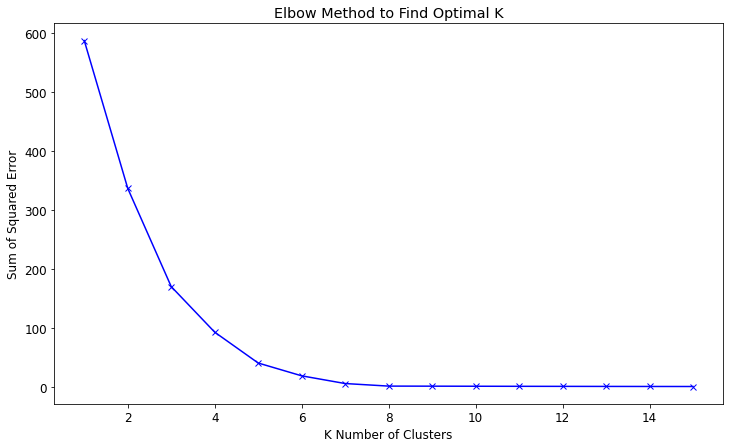

Using the elbow method, the optimal number of clusters is 5


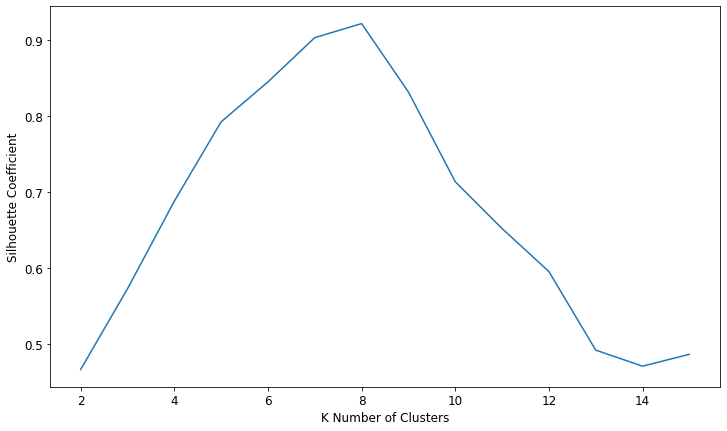

Using Silhouette Scores, the optimal number of clusters is 8


In [12]:
# Find optimal K
clusterFindK(data)

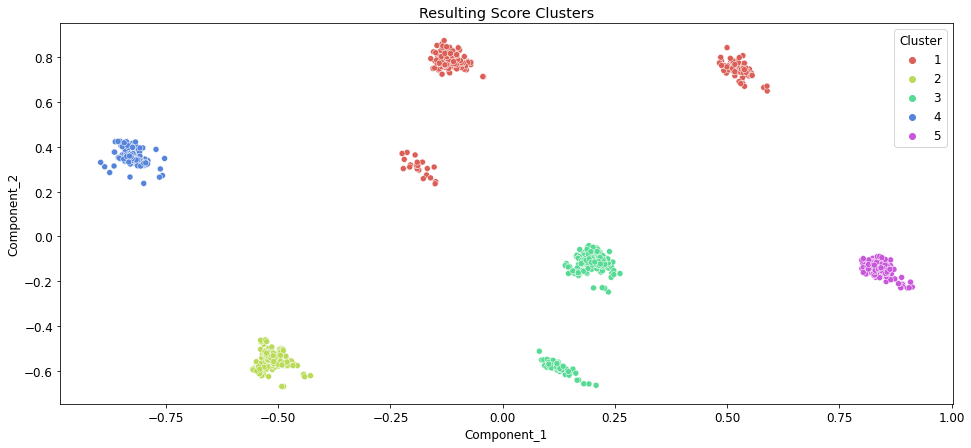

Age  Gender  Race   EjF   RAP   PAS   PAD  PAMN  PCWP    CO  ...  \
ID                                                                     ...   
72       88.0     2.0   1.0  25.0  24.0  42.0  24.0  30.0  36.0  2.20  ...   
72       88.0     2.0   1.0  25.0  18.0  42.0  24.0  30.0  24.0  3.10  ...   
81       69.0     1.0   1.0  20.0  10.0  40.0  20.0  27.0  18.0  4.52  ...   
81       69.0     1.0   1.0  20.0  12.0  35.0  15.0  25.0  17.0  4.65  ...   
814      58.0     1.0   1.0   NaN   3.0  51.0  19.0  30.0  18.0  4.10  ...   
...       ...     ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
Z958018  55.0     2.0   NaN   NaN  20.0  45.0  20.0  29.0  20.0  1.97  ...   
Z958018  55.0     2.0   NaN   NaN   6.0  43.0  19.0  30.0  20.0  3.20  ...   
Z958018  55.0     2.0   NaN   NaN  12.0  47.0  26.0  35.0  32.0  0.93  ...   
Z98220   46.0     1.0   NaN   NaN  12.0  92.0  52.5  67.0  26.0  1.97  ...   
Z98220   46.0     1.0   NaN   NaN   6.0  71.0  34.0  47.0  25.0  4.47  ...   

             SAPi   CPP    PRAPRat  Dth  Rhp  Rdm  cluster  Death  Rehosp  \
ID                                                                          
72       0.777778  50.0   1.166667    1    1  0.0        3      1       1   
72       1.000000  50.0   1.333333    1    1  0.0        3      1       1   
81       0.944444  45.0   1.700000    0    1  0.0        2      0       1   
81       2.352941  45.0   3.333333    0    1  0.0        2      0       1   
814      1.888889  44.0  11.333333    0    0  0.0        4      0       0   
...           ...   ...        ...  ...  ...  ...      ...    ...     ...   
Z958018  2.250000  44.0   2.250000    0    1  NaN        0      0       1   
Z958018  2.250000  44.0   7.500000    0    1  NaN        0      0       1   
Z958018  1.406250  32.0   3.750000    0    1  NaN        0      0       1   
Z98220   1.923077  60.0   4.166667    0    1  NaN        2      0       1   
Z98220   2.000000  61.0   8.333333    0    1  NaN        2      0       1   

         Readmission  
ID                    
72               0.0  
72               0.0  
81               0.0  
81               0.0  
814              0.0  
...              ...  
Z958018          NaN  
Z958018          NaN  
Z958018          NaN  
Z98220           NaN  
Z98220           NaN  

[1128 rows x 35 columns]

In [13]:
# Do clustering using optimal k
k = 5
clusterModel = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
hemoDF, descSummary, clusters, clusterDesc = runClustering(clusterModel=clusterModel, k=k, data=data, origData=hemoOrig, labels=hemoLabels, 
                                    modelName=hemoModelName, columns=['Gender', 'CPI'], pca=pcaFlag)
hemoDF

In [14]:
# Assign final scores
scoreAsmts, finalScores = assignScoresFromClusters(descSummary, k)
scoreAsmts

DeathMean  DeathScores  RehospMean  RehospScores  ReadmMean  \
Cluster                                                                
0         0.088983            2    0.593220             2   0.111111   
1         1.000000            4    1.000000             4   0.448276   
2         0.231975            3    0.768025             3   0.179487   
3         1.000000            5    1.000000             5   0.300000   
4         0.000000            1    0.000000             1   0.000000   

         ReadmScores  AveScores  
Cluster                          
0                  2   2.000000  
1                  5   4.333333  
2                  3   3.000000  
3                  4   4.666667  
4                  1   1.000000

In [15]:
print(finalScores)
scoreAsmts['FinalScores'] = finalScores
scoreAsmts

[2, 4, 3, 5, 1]


DeathMean  DeathScores  RehospMean  RehospScores  ReadmMean  \
Cluster                                                                
0         0.088983            2    0.593220             2   0.111111   
1         1.000000            4    1.000000             4   0.448276   
2         0.231975            3    0.768025             3   0.179487   
3         1.000000            5    1.000000             5   0.300000   
4         0.000000            1    0.000000             1   0.000000   

         ReadmScores  AveScores  FinalScores  
Cluster                                       
0                  2   2.000000            2  
1                  5   4.333333            4  
2                  3   3.000000            3  
3                  4   4.666667            5  
4                  1   1.000000            1

In [16]:
# Look at stats of each cluster
getClusterStats(clusters, clusterDesc)

Cluster  0


Age  Gender       Race         EjF         RAP         PAS  \
count  236.000000   236.0  90.000000  184.000000  227.000000  230.000000   
mean    56.991525     2.0   5.955556   28.032609   12.139501   50.769203   
std     14.332523     0.0  19.977465   15.660033    7.387196   16.632075   
min     24.000000     2.0   1.000000   10.000000    0.000000   13.000000   
25%     48.000000     2.0   1.000000   17.500000    6.000000   39.250000   
50%     55.000000     2.0   2.000000   22.500000   11.000000   48.166667   
75%     70.000000     2.0   2.000000   30.000000   17.000000   60.000000   
max     87.000000     2.0  98.000000   70.000000   34.000000  109.500000   

              PAD        PAMN        PCWP          CO  ...        SAPi  \
count  230.000000  229.000000  222.000000  225.000000  ...  209.000000   
mean    23.279710   33.840975   20.419444    4.182822  ...    3.381994   
std      9.288127   11.274042    8.688289    1.996711  ...    4.889136   
min      0.000000    7.000000    1.500000    0.930000  ...    0.320000   
25%     17.000000   26.000000   14.250000    3.070000  ...    1.666667   
50%     22.500000   33.000000   20.000000    3.900000  ...    2.400000   
75%     30.000000   41.000000   26.000000    4.930000  ...    3.944444   
max     60.000000   79.000000   45.000000   25.000000  ...   66.666667   

              CPP     PRAPRat         Dth         Rhp        Rdm  cluster  \
count  212.000000  214.000000  236.000000  236.000000  90.000000    236.0   
mean    40.796619    7.301132    0.088983    0.593220   0.111111      0.0   
std     14.419216    8.852332    0.285324    0.492277   0.316030      0.0   
min    -36.500000    0.000000    0.000000    0.000000   0.000000      0.0   
25%     33.000000    2.651961    0.000000    0.000000   0.000000      0.0   
50%     40.000000    4.485294    0.000000    1.000000   0.000000      0.0   
75%     48.000000    7.475000    0.000000    1.000000   0.000000      0.0   
max     73.000000   60.000000    1.000000    1.000000   1.000000      0.0   

            Death      Rehosp  Readmission  
count  236.000000  236.000000    90.000000  
mean     0.088983    0.593220     0.111111  
std      0.285324    0.492277     0.316030  
min      0.000000    0.000000     0.000000  
25%      0.000000    0.000000     0.000000  
50%      0.000000    1.000000     0.000000  
75%      0.000000    1.000000     0.000000  
max      1.000000    1.000000     1.000000  

[8 rows x 35 columns]

Cluster  1


Age  Gender       Race         EjF         RAP         PAS  \
count  230.000000   230.0  58.000000  167.000000  219.000000  222.000000   
mean    58.204348     1.0   4.827586   22.446108   13.344368   53.064414   
std     13.879927     0.0  17.786391   12.106086    8.018227   14.825581   
min     21.000000     1.0   1.000000    0.000000  -43.000000   24.000000   
25%     50.250000     1.0   1.000000   15.000000    8.000000   43.041667   
50%     59.000000     1.0   1.000000   17.500000   12.000000   52.000000   
75%     68.000000     1.0   2.000000   25.000000   19.000000   62.000000   
max     88.000000     1.0  98.000000   67.500000   33.500000  109.000000   

              PAD        PAMN        PCWP          CO  ...        SAPi  \
count  222.000000  224.000000  219.000000  225.000000  ...  219.000000   
mean    25.201902   36.132887   23.193075    4.534200  ...    2.174888   
std      9.009330    9.900536    8.453595    1.483372  ...    1.504490   
min      3.500000   12.000000    4.000000    1.980000  ...    0.439024   
25%     20.000000   29.000000   18.000000    3.600000  ...    1.166667   
50%     24.500000   35.750000   22.500000    4.250000  ...    1.750000   
75%     30.000000   42.000000   28.500000    5.130000  ...    2.644269   
max     59.000000   74.000000   50.000000   10.150000  ...    9.500000   

              CPP     PRAPRat    Dth    Rhp        Rdm  cluster  Death  \
count  226.000000  219.000000  230.0  230.0  58.000000    230.0  230.0   
mean    35.534145    4.364261    1.0    1.0   0.448276      1.0    1.0   
std     20.422226    4.124887    0.0    0.0   0.501661      0.0    0.0   
min    -36.000000   -0.813953    1.0    1.0   0.000000      1.0    1.0   
25%     29.000000    2.000000    1.0    1.0   0.000000      1.0    1.0   
50%     37.000000    3.285714    1.0    1.0   0.000000      1.0    1.0   
75%     47.000000    5.348485    1.0    1.0   1.000000      1.0    1.0   
max    109.000000   32.000000    1.0    1.0   1.000000      1.0    1.0   

       Rehosp  Readmission  
count   230.0    58.000000  
mean      1.0     0.448276  
std       0.0     0.501661  
min       1.0     0.000000  
25%       1.0     0.000000  
50%       1.0     0.000000  
75%       1.0     1.000000  
max       1.0     1.000000  

[8 rows x 35 columns]

Cluster  2


Age  Gender        Race         EjF         RAP         PAS  \
count  319.000000   319.0  156.000000  270.000000  298.000000  302.000000   
mean    57.617555     1.0    1.564103   21.335185   12.582550   50.332800   
std     12.720427     0.0    0.888489   10.829091    8.220228   15.924623   
min     23.000000     1.0    1.000000    5.000000    0.000000   18.000000   
25%     50.000000     1.0    1.000000   15.000000    7.000000   40.000000   
50%     58.000000     1.0    1.000000   17.500000   11.000000   50.000000   
75%     66.000000     1.0    2.000000   22.500000   17.000000   60.375000   
max     85.000000     1.0    4.000000   67.500000   71.000000  122.500000   

              PAD        PAMN        PCWP          CO  ...        SAPi  \
count  302.000000  304.000000  292.000000  297.000000  ...  292.000000   
mean    23.926288   33.865881   21.077177    4.740758  ...         inf   
std      8.855351   11.397110    9.183319    2.111609  ...         NaN   
min      5.000000    1.000000    0.000000    0.500000  ...   -1.851852   
25%     18.000000   26.375000   14.375000    3.500000  ...    1.406818   
50%     24.000000   33.000000   21.250000    4.370000  ...    2.106079   
75%     29.500000   42.000000   26.000000    5.500000  ...    3.415966   
max     52.500000   82.000000   53.000000   19.000000  ...         inf   

              CPP     PRAPRat         Dth         Rhp         Rdm  cluster  \
count  303.000000  298.000000  319.000000  319.000000  156.000000    319.0   
mean    40.212753         inf    0.231975    0.768025    0.179487      2.0   
std     19.076768         NaN    0.422756    0.422756    0.384996      0.0   
min    -46.000000   -8.333333    0.000000    0.000000    0.000000      2.0   
25%     33.000000    2.338235    0.000000    1.000000    0.000000      2.0   
50%     41.000000    3.800000    0.000000    1.000000    0.000000      2.0   
75%     51.375000    6.750000    0.000000    1.000000    0.000000      2.0   
max     94.000000         inf    1.000000    1.000000    1.000000      2.0   

            Death      Rehosp  Readmission  
count  319.000000  319.000000   156.000000  
mean     0.231975    0.768025     0.179487  
std      0.422756    0.422756     0.384996  
min      0.000000    0.000000     0.000000  
25%      0.000000    1.000000     0.000000  
50%      0.000000    1.000000     0.000000  
75%      0.000000    1.000000     0.000000  
max      1.000000    1.000000     1.000000  

[8 rows x 35 columns]

Cluster  3


Age  Gender       Race         EjF         RAP           PAS  \
count  150.000000   150.0  20.000000  117.000000  145.000000    146.000000   
mean    60.833333     2.0   2.000000   29.478632   11.531034    127.269977   
std     13.134522     0.0   1.376494   18.904067   12.978689    902.436150   
min     20.000000     2.0   1.000000   10.000000 -123.500000     23.000000   
25%     57.000000     2.0   1.000000   15.000000    7.000000     41.000000   
50%     63.000000     2.0   1.000000   17.500000   11.000000     49.000000   
75%     70.000000     2.0   4.000000   42.500000   17.000000     65.000000   
max     88.000000     2.0   4.000000   70.000000   30.000000  10955.000000   

                PAD        PAMN        PCWP          CO  ...        SAPi  \
count    146.000000  146.000000  145.000000  145.000000  ...  145.000000   
mean      97.804795   34.881279   21.347537    4.125103  ...    2.924888   
std      903.391771   10.073788    8.437521    1.568586  ...    1.891484   
min        7.000000   17.000000    5.000000    1.700000  ...    0.444444   
25%       18.000000   28.000000   16.000000    3.100000  ...    1.714286   
50%       23.000000   33.000000   20.000000    3.970000  ...    2.564103   
75%       27.000000   41.750000   25.000000    5.130000  ...    3.333333   
max    10938.333333   65.000000   50.000000   10.980000  ...   12.000000   

              CPP     PRAPRat    Dth    Rhp        Rdm  cluster  Death  \
count  145.000000  144.000000  150.0  150.0  20.000000    150.0  150.0   
mean    28.942118    5.977528    1.0    1.0   0.300000      3.0    1.0   
std     24.979591    5.466230    0.0    0.0   0.470162      0.0    0.0   
min    -38.500000   -0.647773    1.0    1.0   0.000000      3.0    1.0   
25%     25.000000    2.817647    1.0    1.0   0.000000      3.0    1.0   
50%     36.000000    4.363971    1.0    1.0   0.000000      3.0    1.0   
75%     44.000000    6.631818    1.0    1.0   1.000000      3.0    1.0   
max     73.000000   40.000000    1.0    1.0   1.000000      3.0    1.0   

       Rehosp  Readmission  
count   150.0    20.000000  
mean      1.0     0.300000  
std       0.0     0.470162  
min       1.0     0.000000  
25%       1.0     0.000000  
50%       1.0     0.000000  
75%       1.0     1.000000  
max       1.0     1.000000  

[8 rows x 35 columns]

Cluster  4


Age  Gender       Race         EjF         RAP         PAS  \
count  193.000000   193.0  94.000000  186.000000  181.000000  177.000000   
mean    54.424870     1.0   5.574468   22.026882   10.892726   45.823446   
std     14.012487     0.0  19.608803   11.879659    8.522929   14.181062   
min     26.000000     1.0   1.000000    5.000000    0.000000   20.000000   
25%     42.000000     1.0   1.000000   15.000000    6.000000   36.000000   
50%     56.000000     1.0   1.000000   17.500000    9.500000   45.000000   
75%     66.000000     1.0   2.000000   25.000000   14.000000   54.000000   
max     80.000000     1.0  98.000000   70.000000   85.000000   83.000000   

              PAD        PAMN          PCWP          CO  ...        SAPi  \
count  177.000000  183.000000    175.000000  177.000000  ...  167.000000   
mean    21.428437   30.883880    206.594762    4.724859  ...    2.809174   
std      8.869702   10.563492   1745.820722    1.508341  ...    1.621424   
min      4.000000    1.000000      5.000000    2.280000  ...   -0.666667   
25%     15.000000   23.000000     13.000000    3.700000  ...    1.691852   
50%     20.000000   30.000000     18.000000    4.540000  ...    2.550000   
75%     26.500000   38.000000     26.500000    5.500000  ...    3.763636   
max     46.000000   66.000000  16397.000000   10.900000  ...    8.400000   

                CPP     PRAPRat    Dth    Rhp   Rdm  cluster  Death  Rehosp  \
count    181.000000  173.000000  193.0  193.0  94.0    193.0  193.0   193.0   
mean    -140.901013    7.082816    0.0    0.0   0.0      4.0    0.0     0.0   
std     1717.175431    8.060815    0.0    0.0   0.0      0.0    0.0     0.0   
min   -16340.000000   -6.875000    0.0    0.0   0.0      4.0    0.0     0.0   
25%       32.000000    2.562500    0.0    0.0   0.0      4.0    0.0     0.0   
50%       44.000000    4.750000    0.0    0.0   0.0      4.0    0.0     0.0   
75%       54.000000    8.333333    0.0    0.0   0.0      4.0    0.0     0.0   
max       72.000000   63.000000    0.0    0.0   0.0      4.0    0.0     0.0   

       Readmission  
count         94.0  
mean           0.0  
std            0.0  
min            0.0  
25%            0.0  
50%            0.0  
75%            0.0  
max            0.0  

[8 rows x 35 columns]

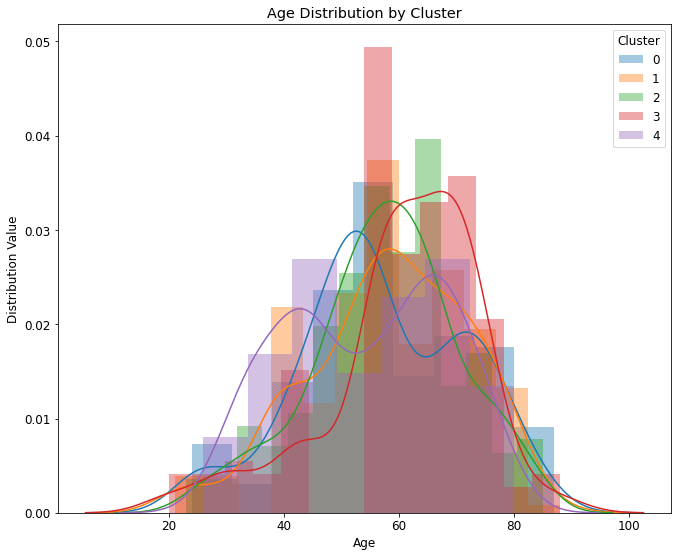

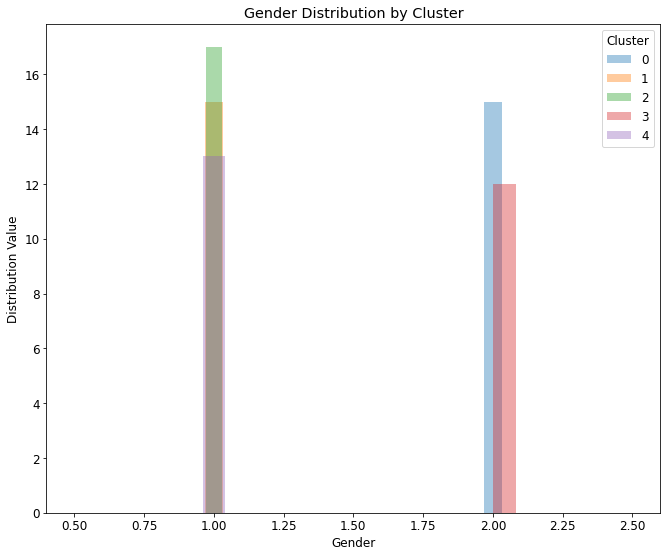

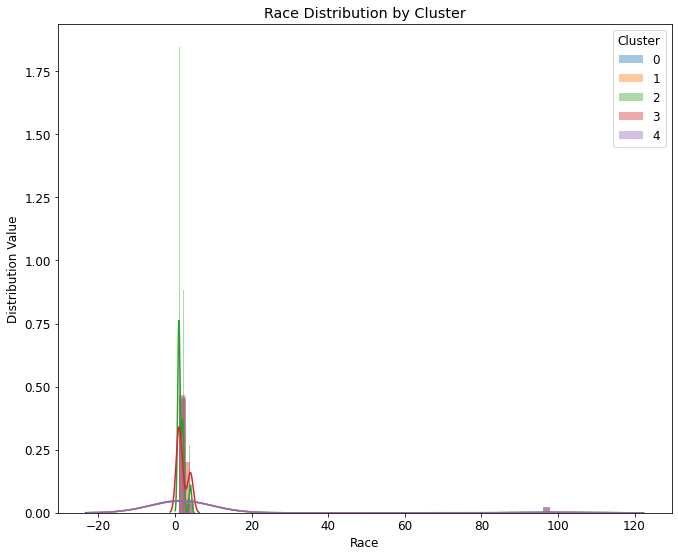

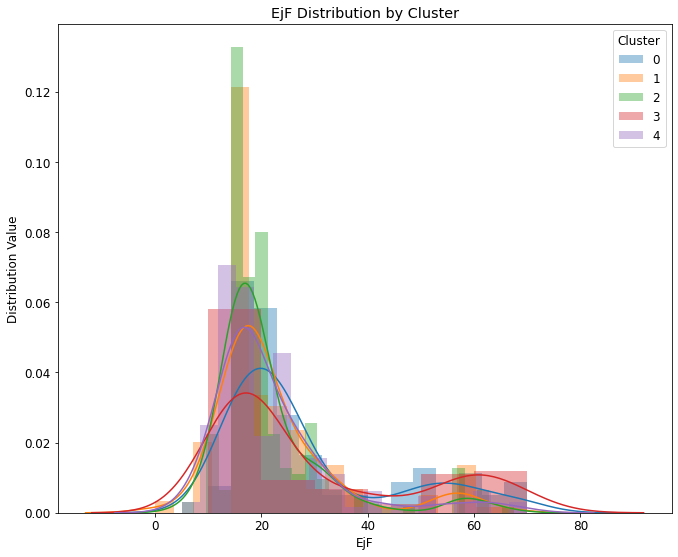

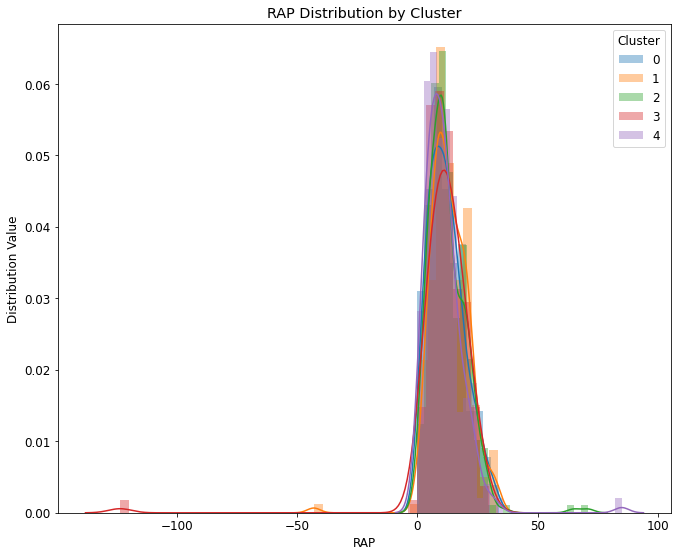

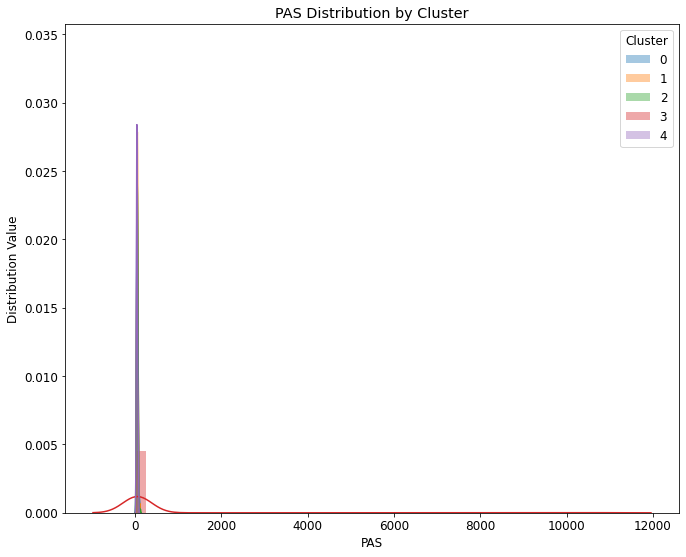

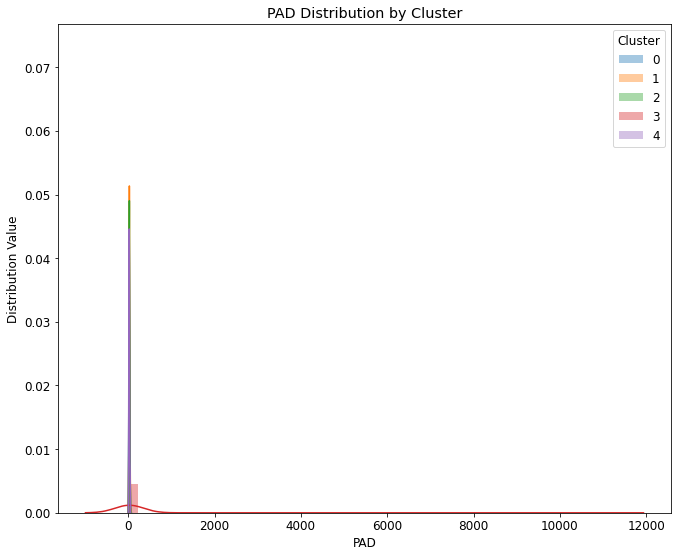

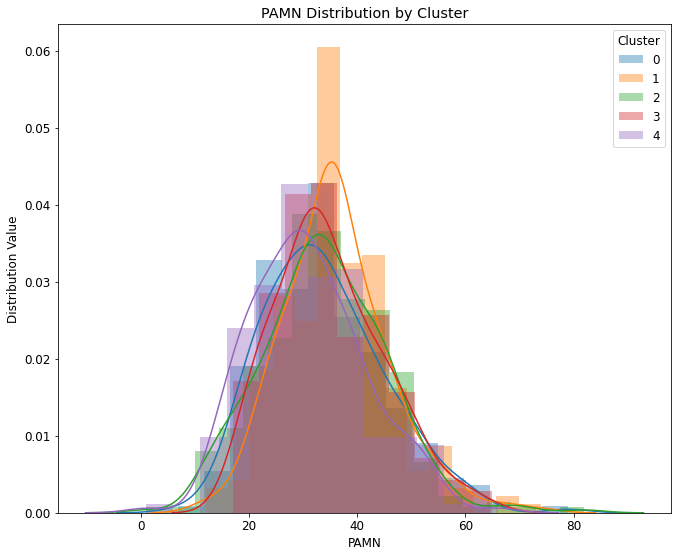

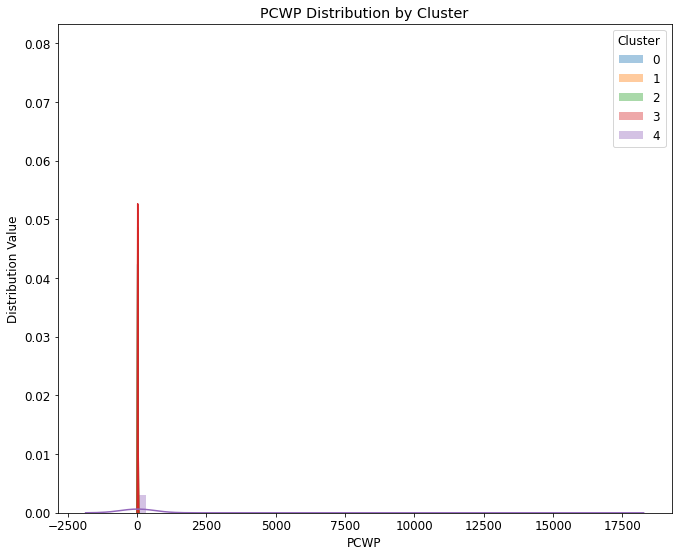

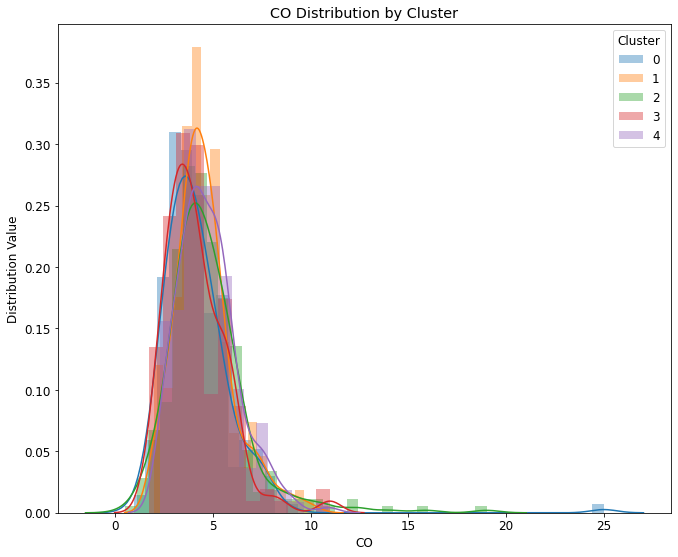

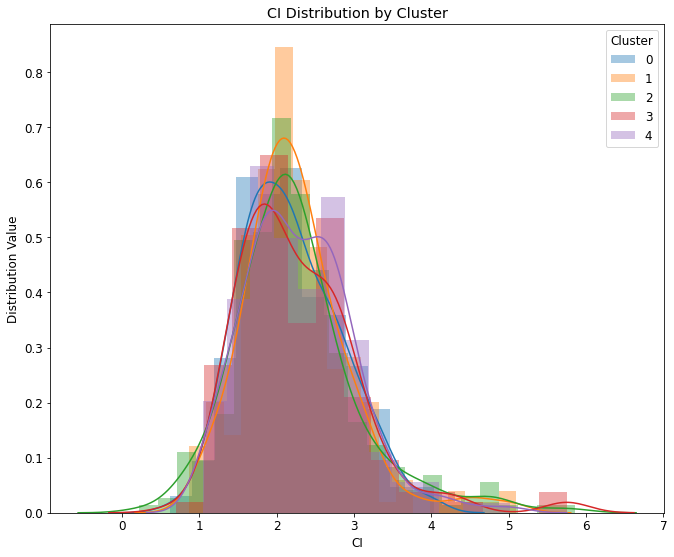

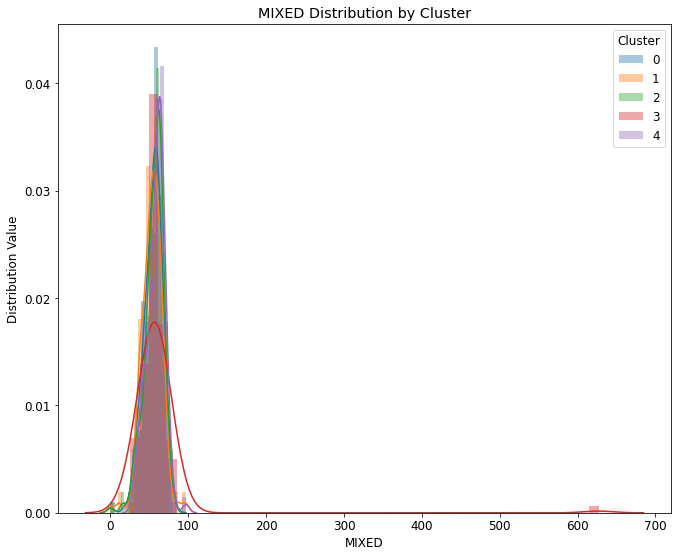

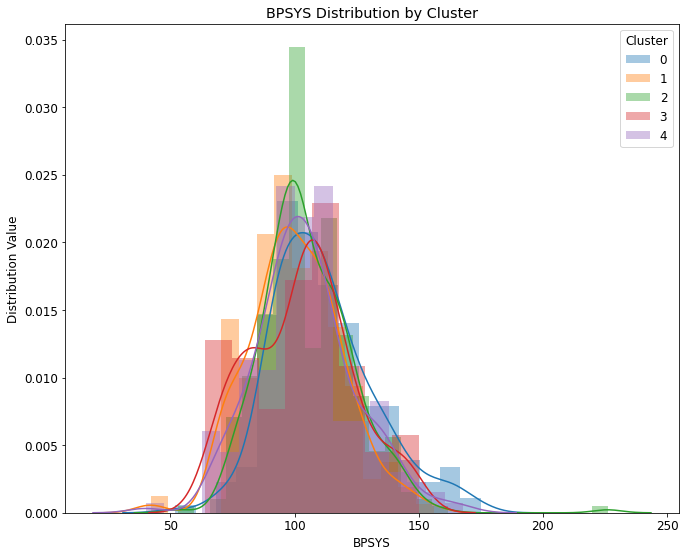

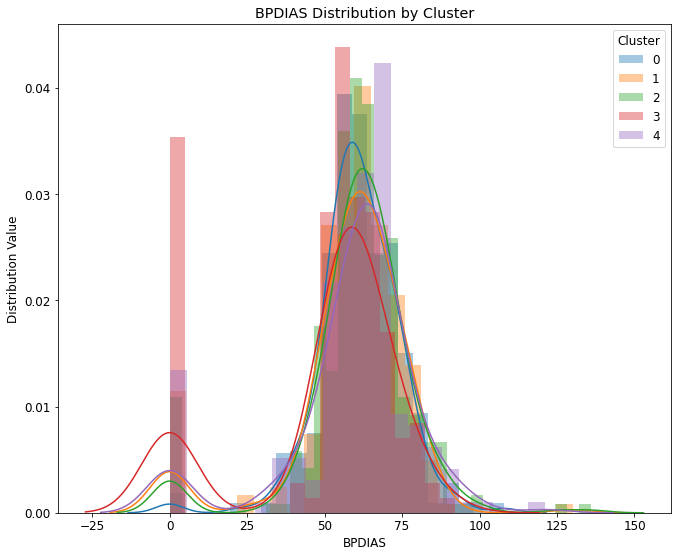

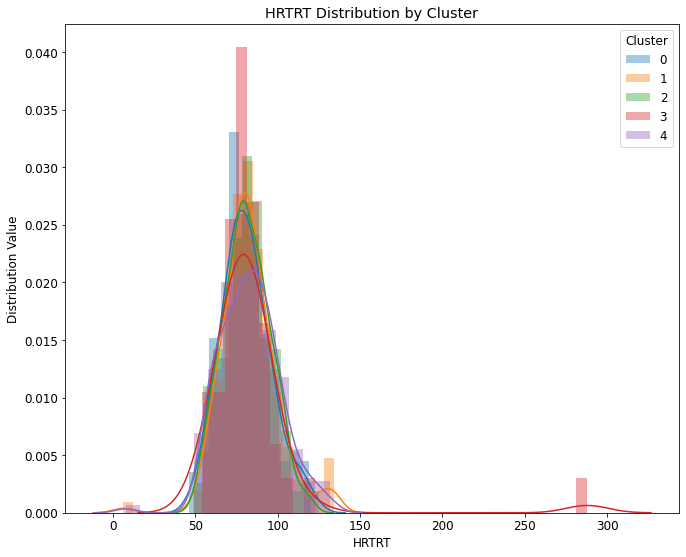

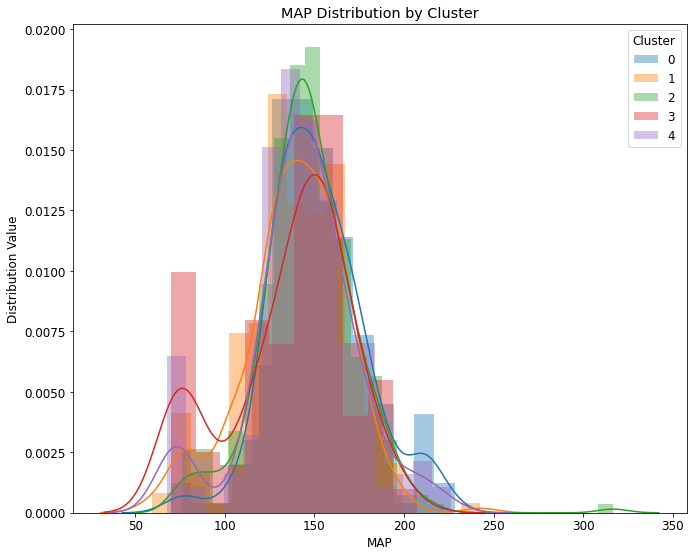

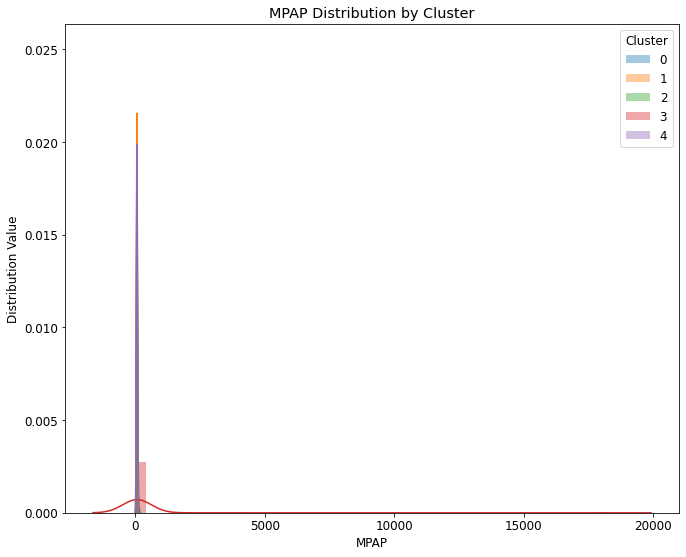

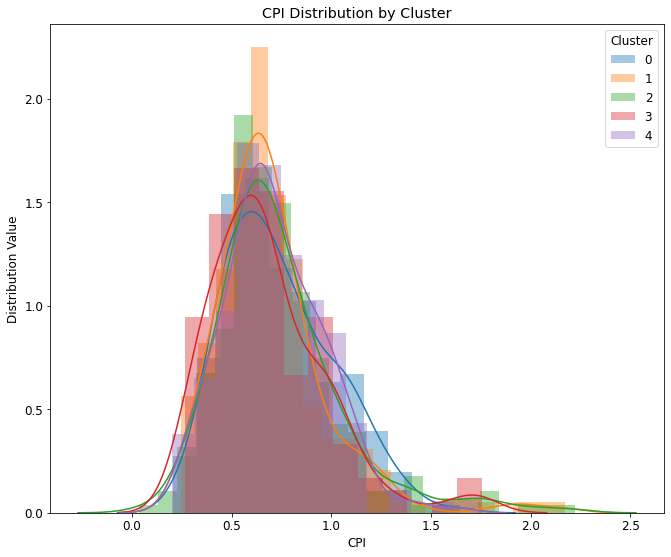

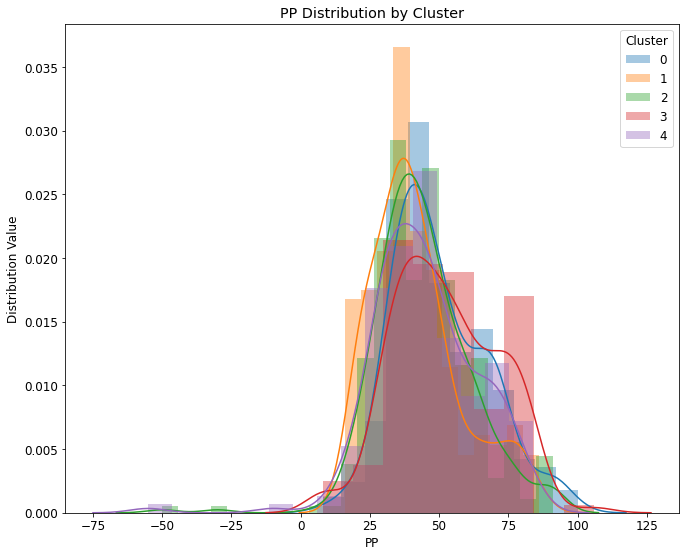

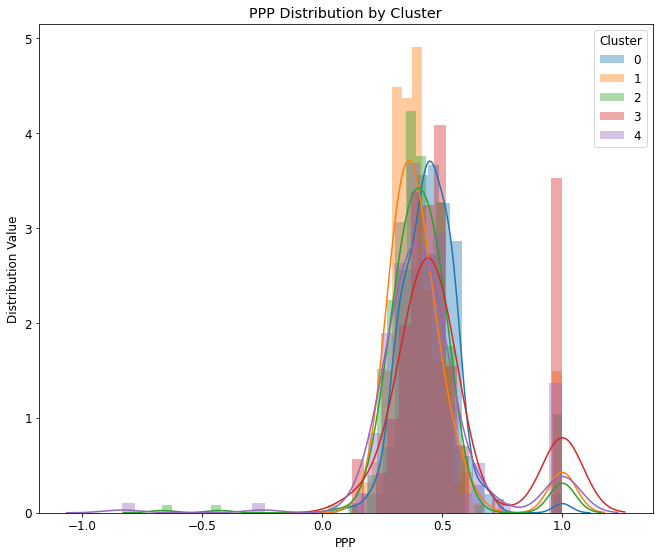

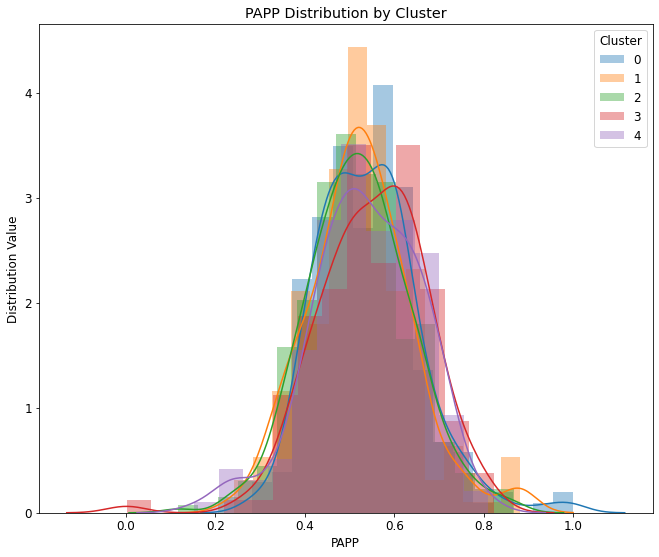

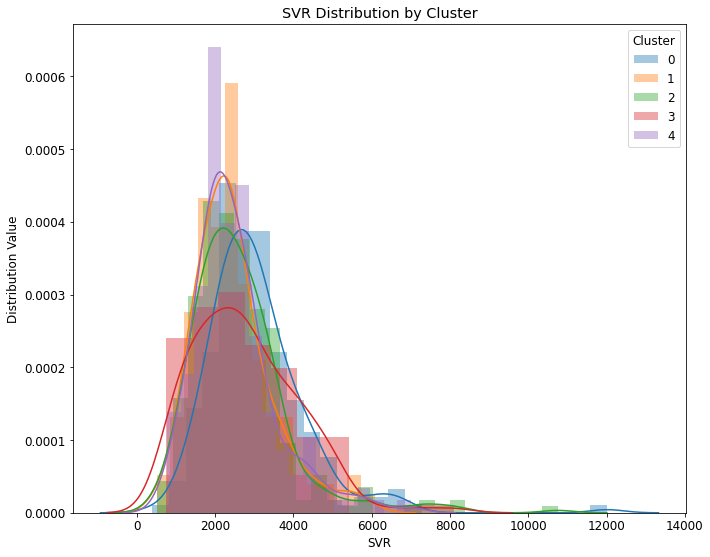

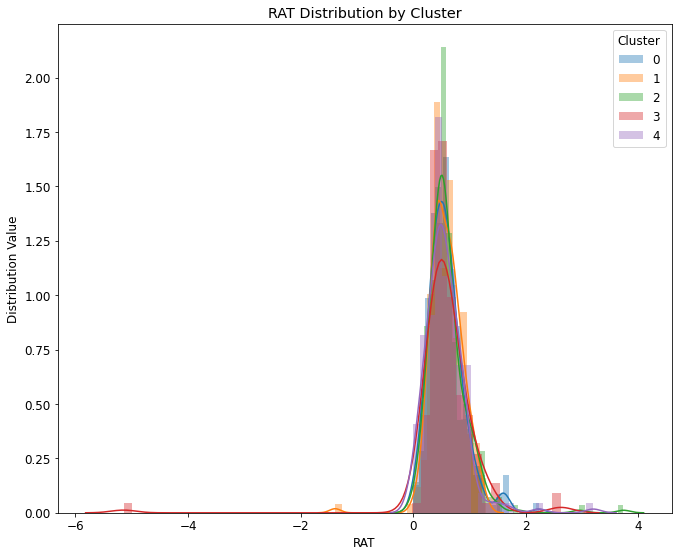

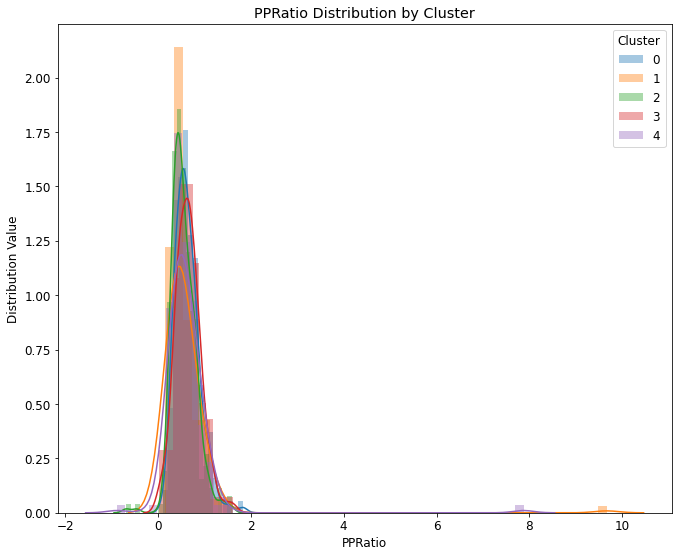

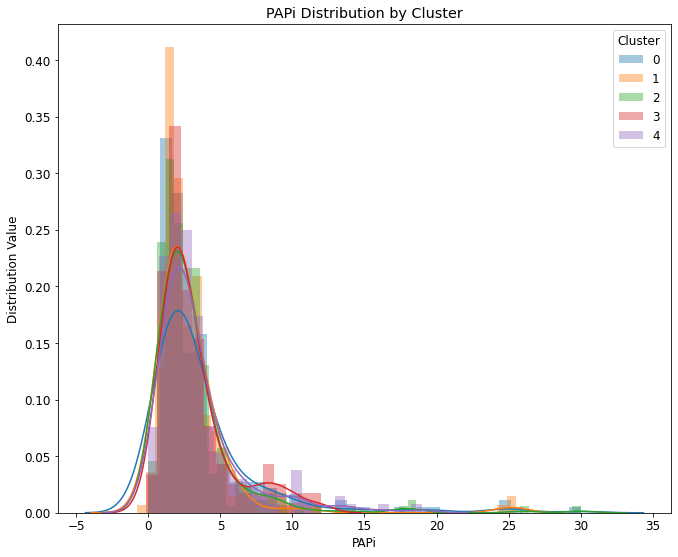

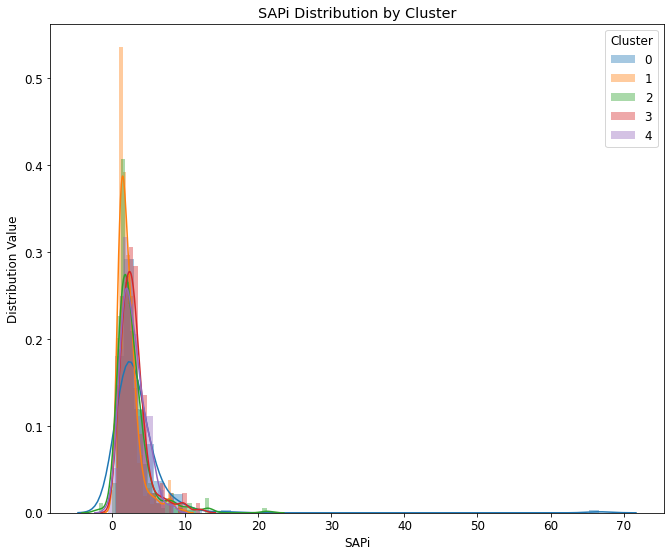

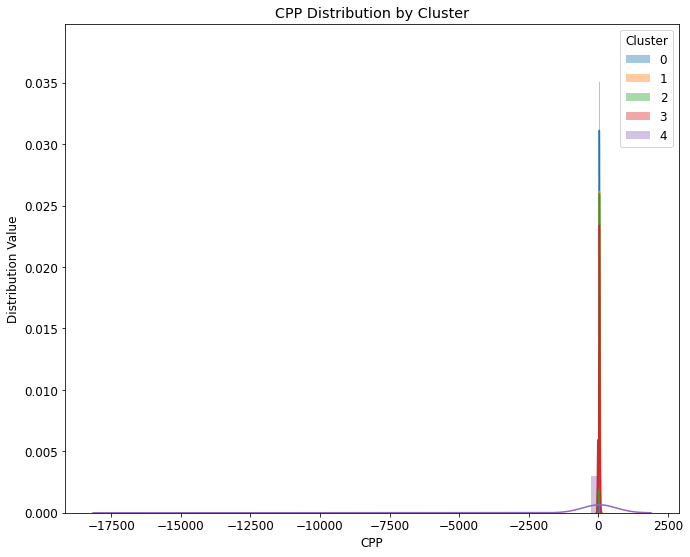

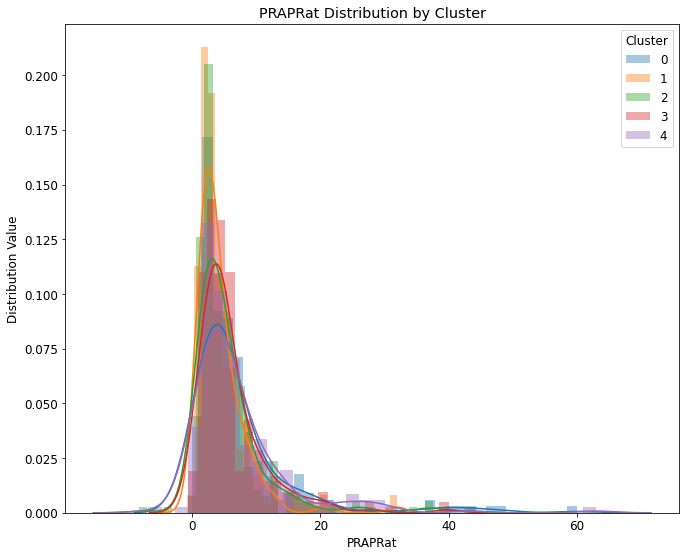

In [17]:
colss = ['Age', 'Gender', 'Race', 'EjF', 'RAP', 'PAS', 'PAD', 'PAMN', 'PCWP', 'CO',
       'CI', 'MIXED', 'BPSYS', 'BPDIAS', 'HRTRT',  'MAP',
       'MPAP', 'CPI', 'PP', 'PPP', 'PAPP', 'SVR', 'RAT', 'PPRatio', 'PAPi', 'SAPi', 'CPP',
       'PRAPRat']

distPlotsForClusters(cls=clusters, cols=colss, name="Hemo")

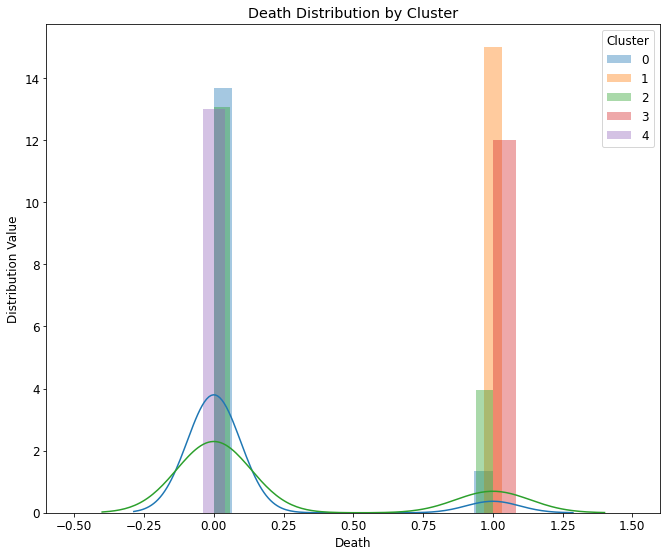

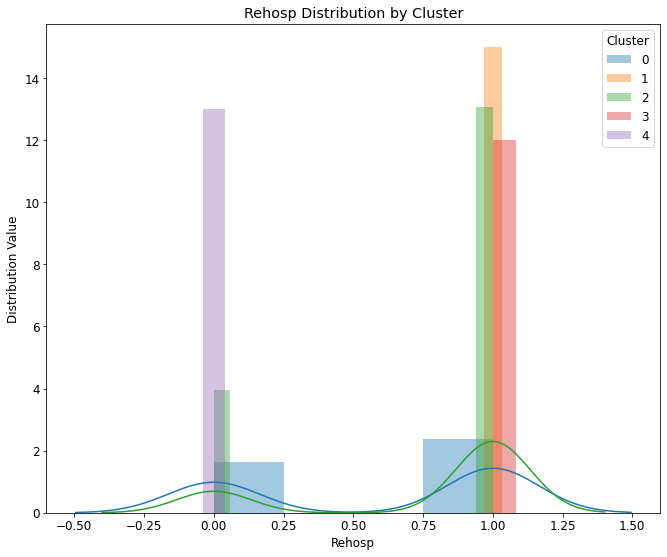

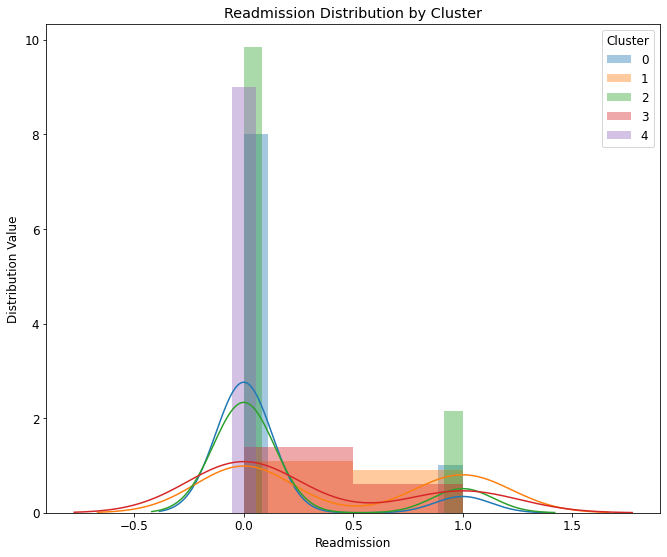

In [18]:
colss= ['Death', 'Rehosp', 'Readmission']
distPlotsForClusters(cls=clusters, cols=colss, name="Hemo")

In [19]:
# Drop labels
hemoDF = hemoDF.drop(columns=(['Dth', 'Rhp', 'Rdm']))

In [20]:
#Save separate datasets
escIndx = sorted(list(set(escapeHemo.index)))
escH = hemoDF.loc[escIndx,:]


escH = saveClusteredData(escH, scoreAsmts,"Data/Preprocessed Data/ESCAPE_Hemo.csv")
escH

Age  Gender  Race   EjF   RAP   PAS   PAD  PAMN  PCWP    CO  ...  \
ID                                                                   ...   
72     88.0     2.0   1.0  25.0  24.0  42.0  24.0  30.0  36.0  2.20  ...   
72     88.0     2.0   1.0  25.0  18.0  42.0  24.0  30.0  24.0  3.10  ...   
81     69.0     1.0   1.0  20.0  10.0  40.0  20.0  27.0  18.0  4.52  ...   
81     69.0     1.0   1.0  20.0  12.0  35.0  15.0  25.0  17.0  4.65  ...   
814    58.0     1.0   1.0   NaN   3.0  51.0  19.0  30.0  18.0  4.10  ...   
...     ...     ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
98508  57.0     1.0  98.0  30.0   NaN   NaN   NaN   NaN   NaN   NaN  ...   
99302  41.0     1.0   2.0  15.0  19.0  87.0  37.0  54.0  44.0  3.90  ...   
99302  41.0     1.0   2.0  15.0  11.0  70.0  28.0  44.0  28.0  5.30  ...   
99935  64.0     2.0   1.0  20.0   8.0  49.0  29.0  31.0  15.0  4.00  ...   
99935  64.0     2.0   1.0  20.0   8.0  52.0  24.0  39.0  24.0  5.60  ...   

            RAT   PPRatio       PAPi      SAPi   CPP    PRAPRat  Score  \
ID                                                                       
72     0.666667  0.266667   0.750000  0.777778  50.0   1.166667      5   
72     0.750000  0.272727   1.000000  1.000000  50.0   1.333333      5   
81     0.555556  0.242857   2.000000  0.944444  45.0   1.700000      3   
81     0.705882  0.571429   1.666667  2.352941  45.0   3.333333      3   
814    0.166667  0.566667  10.666667  1.888889  44.0  11.333333      1   
...         ...       ...        ...       ...   ...        ...    ...   
98508       NaN       NaN        NaN       NaN  37.0        NaN      1   
99302  0.431818  0.642857   2.631579  1.227273  13.0   2.842105      4   
99302  0.392857  1.088608   3.818182  3.071429  13.0   7.818182      4   
99935  0.533333  1.253333   2.500000  6.266667  30.0  11.750000      2   
99935  0.333333  0.888889   3.500000  3.000000  30.0   9.000000      2   

       ScoreDeath  ScoreRehosp  ScoreReadmission  
ID                                                
72              5            5                 4  
72              5            5                 4  
81              3            3                 3  
81              3            3                 3  
814             1            1                 1  
...           ...          ...               ...  
98508           1            1                 1  
99302           4            4                 5  
99302           4            4                 5  
99935           2            2                 2  
99935           2            2                 2  

[418 rows x 32 columns]

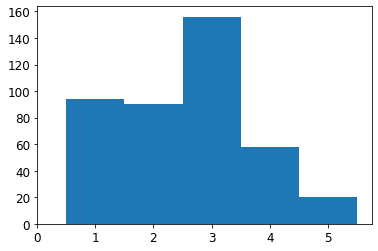

In [21]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(escH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

In [22]:
shockIndx = sorted(list(set(cardShockHemo.index)))
csH = hemoDF.loc[shockIndx,:]

csH = saveClusteredData(csH, scoreAsmts,"Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_Hemo.csv")
csH

Age  Gender  Race   EjF   RAP   PAS   PAD  PAMN  PCWP    CO  ...  \
ID                                                                      ...   
Z1017923  62.0     1.0   NaN  22.5   9.0  38.0  20.0  26.0  15.0  7.50  ...   
Z1024990  59.0     1.0   NaN  17.5  12.0  51.0  33.0  39.0  31.0  5.67  ...   
Z104044   65.0     1.0   NaN   NaN  12.0  61.8  21.6  36.6  26.0  4.13  ...   
Z1099417  37.0     2.0   NaN  27.5  32.0  58.0  34.0  44.0  21.0  3.39  ...   
Z1140320  61.0     2.0   NaN  27.5  19.0  54.0  24.0  38.0  36.0  3.27  ...   
...        ...     ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
Z928524   51.0     1.0   NaN  15.0  16.0  85.0  29.0  50.0  24.0  7.13  ...   
Z928524   51.0     1.0   NaN  27.5  21.0  62.0  32.0  42.0  23.0  2.03  ...   
Z928524   51.0     1.0   NaN  27.5  23.0  67.0  35.0  45.0  21.0  4.20  ...   
Z93161    71.0     1.0   NaN  27.5   NaN  28.0  17.0  21.0  14.0  2.57  ...   
Z96296    70.0     2.0   NaN  67.5   4.0  31.0  11.0  18.0   7.0  3.50  ...   

               RAT   PPRatio      PAPi      SAPi   CPP    PRAPRat  Score  \
ID                                                                         
Z1017923  0.600000  0.313131  2.000000  2.066667  56.0   3.444444      4   
Z1024990  0.387097  0.608696  1.500000  2.258065  25.0   5.833333      3   
Z104044   0.461538       NaN  3.350000  2.038462  40.0   4.416667      4   
Z1099417  1.523810  0.369369  0.750000  1.952381  30.0   1.281250      2   
Z1140320  0.527778  0.430233  1.578947  1.027778  32.0   1.947368      5   
...            ...       ...       ...       ...   ...        ...    ...   
Z928524   0.666667       NaN  3.500000  1.916667  55.0   2.875000      4   
Z928524   0.913043  0.848485  1.428571  2.434783  38.0   2.666667      4   
Z928524   1.095238  0.543689  1.391304  2.666667  40.0   2.434783      4   
Z93161         NaN  0.871795       NaN  4.857143  46.0        NaN      4   
Z96296    0.571429  0.785714  5.000000  7.857143  45.0  13.750000      5   

          ScoreDeath  ScoreRehosp  ScoreReadmission  
ID                                                   
Z1017923           4            4                 5  
Z1024990           3            3                 3  
Z104044            4            4                 5  
Z1099417           2            2                 2  
Z1140320           5            5                 4  
...              ...          ...               ...  
Z928524            4            4                 5  
Z928524            4            4                 5  
Z928524            4            4                 5  
Z93161             4            4                 5  
Z96296             5            5                 4  

[302 rows x 32 columns]

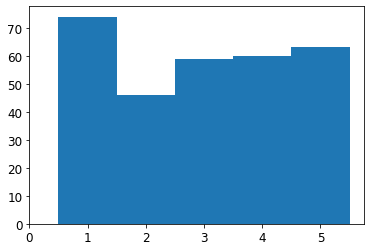

In [23]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(csH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

In [24]:
serialIndx = sorted(list(set(serialHemo.index)))
csH = hemoDF.loc[serialIndx,:]

csH = saveClusteredData(csH, scoreAsmts,"Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_Hemo.csv")
csH

Age  Gender  Race   EjF   RAP        PAS        PAD   PAMN  \
ID                                                                      
Z103426   49.0     2.0   NaN  17.5  25.5  53.750000  31.500000  40.25   
Z103426   49.0     2.0   NaN  17.5  15.0  42.333333  26.333333  33.00   
Z103697   56.0     2.0   NaN  22.5  24.0  67.000000  36.000000  48.00   
Z103697   56.0     2.0   NaN  22.5  17.0  55.000000  23.000000  39.00   
Z1050590  52.0     2.0   NaN  67.5  14.0  94.500000  36.000000  58.50   
...        ...     ...   ...   ...   ...        ...        ...    ...   
Z958018   55.0     2.0   NaN   NaN  20.0  45.000000  20.000000  29.00   
Z958018   55.0     2.0   NaN   NaN   6.0  43.000000  19.000000  30.00   
Z958018   55.0     2.0   NaN   NaN  12.0  47.000000  26.000000  35.00   
Z98220    46.0     1.0   NaN   NaN  12.0  92.000000  52.500000  67.00   
Z98220    46.0     1.0   NaN   NaN   6.0  71.000000  34.000000  47.00   

               PCWP     CO  ...       RAT   PPRatio      PAPi      SAPi  \
ID                          ...                                           
Z103426   25.333333  2.950  ...  1.006579  0.365217  0.872549  1.657895   
Z103426   21.400000  3.800  ...  0.700935  0.368421  1.066667  1.962617   
Z103697   36.000000  2.990  ...  0.666667       NaN  1.291667  0.805556   
Z103697   28.000000  3.710  ...  0.607143       NaN  1.882353  1.035714   
Z1050590  11.500000  4.685  ...  1.217391       NaN  4.178571       NaN   
...             ...    ...  ...       ...       ...       ...       ...   
Z958018   20.000000  1.970  ...  1.000000  0.450000  1.250000  2.250000   
Z958018   20.000000  3.200  ...  0.300000  0.542169  4.000000  2.250000   
Z958018   32.000000  0.930  ...  0.375000  0.450000  1.750000  1.406250   
Z98220    26.000000  1.970  ...  0.461538  0.574713  3.291667  1.923077   
Z98220    25.000000  4.470  ...  0.240000  0.641026  6.166667  2.000000   

                CPP   PRAPRat  Score  ScoreDeath  ScoreRehosp  \
ID                                                              
Z103426   35.666667  1.647059      2           2            2   
Z103426   39.600000  2.800000      2           2            2   
Z103697   26.000000  1.208333      2           2            2   
Z103697   34.000000  1.705882      2           2            2   
Z1050590        NaN       NaN      2           2            2   
...             ...       ...    ...         ...          ...   
Z958018   44.000000  2.250000      2           2            2   
Z958018   44.000000  7.500000      2           2            2   
Z958018   32.000000  3.750000      2           2            2   
Z98220    60.000000  4.166667      3           3            3   
Z98220    61.000000  8.333333      3           3            3   

          ScoreReadmission  
ID                          
Z103426                  2  
Z103426                  2  
Z103697                  2  
Z103697                  2  
Z1050590                 2  
...                    ...  
Z958018                  2  
Z958018                  2  
Z958018                  2  
Z98220                   3  
Z98220                   3  

[556 rows x 32 columns]

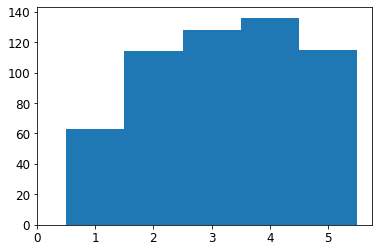

In [25]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(csH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

# ALL DATA

In [26]:
# first - try other clustering methods
allD = copy.deepcopy(allDataOrig)
allData = allD.replace(np.inf, 0)
allData = allData.fillna(0)

if pcaFlag:
    scaler = MinMaxScaler()#scale data
    allData.loc[:,:] = scaler.fit_transform(allData)
    pca = PCA(n_components=2)
    data = pca.fit_transform(allData)
else:
    data=allData

In [27]:
#Explain PCA Components

# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
print(most_important)

initial_feature_names = allData.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())
df

[20, 26]


0     1
0  PC0   HTN
1  PC1  VAHD

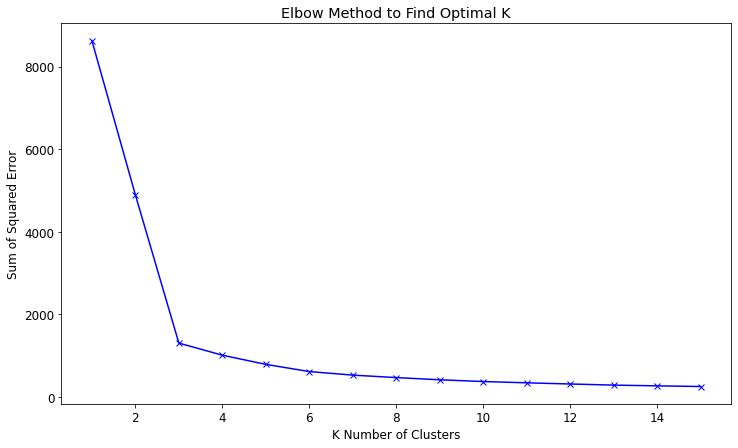

Using the elbow method, the optimal number of clusters is 3


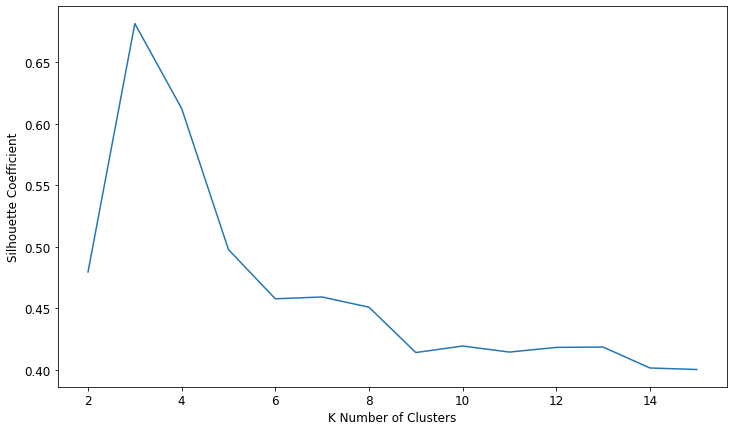

Using Silhouette Scores, the optimal number of clusters is 3


In [28]:
# Find optimal K
clusterFindK(data)

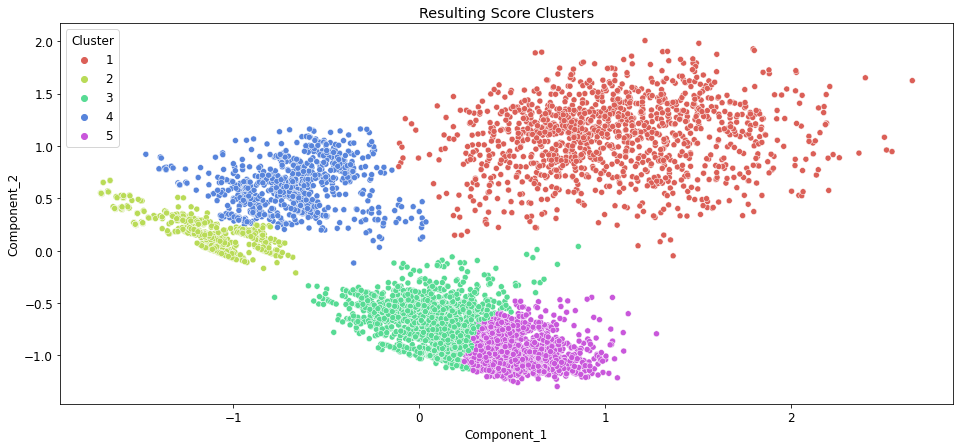

Age  Gender  Race          Wt        BMI  InitialHospDays  \
ID                                                                  
72     88.0     2.0   1.0   57.100000  26.424175              9.0   
72     88.0     2.0   1.0   52.000000  24.064047              9.0   
81     69.0     1.0   1.0  102.363636  32.307675              5.0   
81     69.0     1.0   1.0  100.454545  31.705134              5.0   
86     56.0     2.0   2.0   98.636364  40.016375              3.0   
...     ...     ...   ...         ...        ...              ...   
98788  56.0     1.0   2.0         NaN   0.000000              0.0   
99329  33.0     1.0   2.0  142.400000  52.241316              0.0   
99329  33.0     1.0   2.0         NaN   0.000000              0.0   
99355  46.0     2.0   2.0   75.750703  23.379847              0.0   
99355  46.0     2.0   2.0         NaN   0.000000              0.0   

       TotalHospDays  NYHA  MLHFS   AF  ...     HR         PV         MAP  \
ID                                      ...                                 
72              16.0   4.0   76.0  1.0  ...  104.0  12.452563  139.333333   
72              16.0   3.0   76.0  1.0  ...   92.0  12.452563  126.000000   
81              13.0   4.0   21.0  1.0  ...   70.0  -3.346568  125.333333   
81              13.0   2.0   21.0  1.0  ...   72.0  -3.346568  105.666667   
86               3.0   4.0    NaN  0.0  ...   86.0   5.478621  146.666667   
...              ...   ...    ...  ...  ...    ...        ...         ...   
98788            3.0   NaN    0.0  1.0  ...    0.0   0.000000         NaN   
99329           30.0   3.0    0.0  0.0  ...    0.0   0.000000  135.333333   
99329           30.0   NaN    0.0  0.0  ...    0.0   0.000000         NaN   
99355           19.0   4.0    0.0  0.0  ...    0.0   0.000000  148.333333   
99355           19.0   NaN    0.0  0.0  ...    0.0   0.000000         NaN   

         PP       PPP   PPRatio  cluster  Death  Rehosp  Readmission  
ID                                                                    
72     26.0  0.276596  0.250000        0      1       1          0.0  
72     26.0  0.302326  0.282609        0      1       1          0.0  
81     32.0  0.363636  0.457143        0      0       1          0.0  
81     34.0  0.441558  0.472222        0      0       1          0.0  
86     30.0  0.300000  0.348837        0      0       0          0.0  
...     ...       ...       ...      ...    ...     ...          ...  
98788   NaN       NaN       NaN        3      0       1          NaN  
99329  32.0  0.340426  0.400000        0      0       1          NaN  
99329   NaN       NaN       NaN        3      0       1          NaN  
99355  30.0  0.297030  0.333333        0      1       1          NaN  
99355   NaN       NaN       NaN        3      1       1          NaN  

[5990 rows x 70 columns]

In [29]:
# Cluster using best k
k = 5
clusterModel = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
allDataDF, descSummary, clusters, clusterDesc  = runClustering(clusterModel=clusterModel, k=k, data=data, origData=allDataOrig, labels=allDataLabels, 
                                    modelName=allDataModelName, columns=['MAP', 'BPDIAS'], pca=pcaFlag)
allDataDF

In [30]:
scoreAsmts, finalScores = assignScoresFromClusters(descSummary, k)
scoreAsmts

DeathMean  DeathScores  RehospMean  RehospScores  ReadmMean  \
Cluster                                                                
0         0.258167            1    0.558566             2    0.18648   
1         0.554537            5    0.462878             1    0.00000   
2         0.304768            2    0.601244             3    0.00000   
3         0.360603            4    0.669537             5    0.00000   
4         0.333596            3    0.660883             4    0.12500   

         ReadmScores  AveScores  
Cluster                          
0                  5   2.666667  
1                  1   2.333333  
2                  2   2.333333  
3                  3   4.000000  
4                  4   3.666667

In [31]:
print(finalScores)
scoreAsmts['FinalScores'] = finalScores
scoreAsmts

[3, 2, 1, 5, 4]


DeathMean  DeathScores  RehospMean  RehospScores  ReadmMean  \
Cluster                                                                
0         0.258167            1    0.558566             2    0.18648   
1         0.554537            5    0.462878             1    0.00000   
2         0.304768            2    0.601244             3    0.00000   
3         0.360603            4    0.669537             5    0.00000   
4         0.333596            3    0.660883             4    0.12500   

         ReadmScores  AveScores  FinalScores  
Cluster                                       
0                  5   2.666667            3  
1                  1   2.333333            2  
2                  2   2.333333            1  
3                  3   4.000000            5  
4                  4   3.666667            4

In [32]:
# Look at stats of each cluster
getClusterStats(clusters, clusterDesc)

Cluster  0


Age       Gender         Race           Wt          BMI  \
count  1255.000000  1255.000000  1255.000000  1200.000000  1185.000000   
mean     58.067729     1.389641     1.440637    86.577176    28.854109   
std      14.111519     0.487863     0.496661    23.116430     8.263756   
min      20.000000     1.000000     1.000000    47.000000     0.000000   
25%      49.000000     1.000000     1.000000    69.275000    23.673593   
50%      58.000000     1.000000     1.000000    83.915450    27.861523   
75%      68.000000     2.000000     2.000000    99.300000    33.159801   
max      90.000000     2.000000     2.000000   170.000000    60.726644   

       InitialHospDays  TotalHospDays         NYHA        MLHFS           AF  \
count      1242.000000    1255.000000  1218.000000  1238.000000  1252.000000   
mean          5.734300      14.795219     4.109195    50.023425     0.348243   
std           6.601121      19.067754     8.896394    37.308003     0.476604   
min           0.000000       0.000000     1.000000     0.000000     0.000000   
25%           0.000000       3.000000     3.000000     0.000000     0.000000   
50%           5.000000       9.000000     3.000000    65.000000     0.000000   
75%           8.000000      20.000000     4.000000    81.000000     1.000000   
max          51.000000     154.000000    97.000000   105.000000     1.000000   

       ...           HR           PV          MAP           PP          PPP  \
count  ...  1229.000000  1044.000000  1223.000000  1223.000000  1223.000000   
mean   ...    54.657445    19.078390   151.492232    41.402289     0.380815   
std    ...    39.783461   276.959624    24.238186    13.995968     0.092228   
min    ...     0.000000  -581.505997    84.000000     7.000000     0.083333   
25%    ...     0.000000    -4.998385   133.833333    32.000000     0.316749   
50%    ...    70.000000     0.000000   149.333333    40.000000     0.375000   
75%    ...    84.000000     3.416028   166.000000    49.000000     0.438202   
max    ...   181.000000  5947.841727   283.000000   107.000000     1.000000   

           PPRatio  cluster        Death       Rehosp  Readmission  
count  1216.000000   1255.0  1255.000000  1255.000000   858.000000  
mean      0.542214      0.0     0.258167     0.558566     0.186480  
std       0.229075      0.0     0.437801     0.496756     0.389721  
min       0.071823      0.0     0.000000     0.000000     0.000000  
25%       0.375000      0.0     0.000000     0.000000     0.000000  
50%       0.500000      0.0     0.000000     1.000000     0.000000  
75%       0.666667      0.0     1.000000     1.000000     0.000000  
max       1.563636      0.0     1.000000     1.000000     1.000000  

[8 rows x 70 columns]

Cluster  1


Age       Gender         Race           Wt         BMI  \
count  1091.000000  1091.000000  1091.000000  1084.000000  352.000000   
mean     60.119157     1.365720     0.007333     0.049795   29.062500   
std      18.427704     0.481852     0.085356     1.639450    9.628298   
min     -15.000000     1.000000     0.000000     0.000000    0.000000   
25%      53.000000     1.000000     0.000000     0.000000   23.100000   
50%      63.000000     1.000000     0.000000     0.000000   28.550000   
75%      73.000000     2.000000     0.000000     0.000000   34.200000   
max      89.000000     2.000000     1.000000    53.977492  110.400000   

       InitialHospDays  TotalHospDays         NYHA   MLHFS      AF  ...  \
count       578.000000    1091.000000  1084.000000  1090.0  1090.0  ...   
mean         13.181661      23.291476     0.002768     0.0     0.0  ...   
std          16.054712      24.231061     0.091119     0.0     0.0  ...   
min           0.000000       0.000000     0.000000     0.0     0.0  ...   
25%           3.000000       7.000000     0.000000     0.0     0.0  ...   
50%           8.000000      16.000000     0.000000     0.0     0.0  ...   
75%          16.000000      29.500000     0.000000     0.0     0.0  ...   
max          92.000000     209.000000     3.000000     0.0     0.0  ...   

           HR           PV         MAP          PP         PPP     PPRatio  \
count  1090.0  1091.000000  522.000000  522.000000  522.000000  479.000000   
mean      0.0     0.011776  149.567050   48.245211    0.437010    0.447146   
std       0.0     0.388981   30.533367   18.261305    0.136190    0.231584   
min       0.0     0.000000   59.333333    0.000000    0.000000    0.000000   
25%       0.0     0.000000  131.750000   37.000000    0.364614    0.282758   
50%       0.0     0.000000  148.666667   45.000000    0.433481    0.403101   
75%       0.0     0.000000  167.250000   60.000000    0.502358    0.591153   
max       0.0    12.848140  316.666667  110.000000    1.000000    2.363636   

       cluster        Death       Rehosp  Readmission  
count   1091.0  1091.000000  1091.000000          1.0  
mean       1.0     0.554537     0.462878          0.0  
std        0.0     0.497245     0.498849          NaN  
min        1.0     0.000000     0.000000          0.0  
25%        1.0     0.000000     0.000000          0.0  
50%        1.0     1.000000     0.000000          0.0  
75%        1.0     1.000000     1.000000          0.0  
max        1.0     1.000000     1.000000          0.0  

[8 rows x 70 columns]

Cluster  2


Age       Gender         Race           Wt          BMI  \
count  1447.000000  1447.000000  1447.000000  1444.000000  1446.000000   
mean     58.760194     1.310988     1.253628    81.172375     0.064993   
std      13.095505     0.463058     0.435238    19.021452     1.433137   
min      25.000000     1.000000     1.000000    45.359237     0.000000   
25%      50.000000     1.000000     1.000000    68.038855     0.000000   
50%      60.000000     1.000000     1.000000    78.925072     0.000000   
75%      69.000000     2.000000     2.000000    91.739057     0.000000   
max      85.000000     2.000000     2.000000   149.685482    35.741480   

       InitialHospDays  TotalHospDays         NYHA        MLHFS           AF  \
count      1447.000000    1447.000000  1446.000000  1447.000000  1447.000000   
mean          0.014513       0.031790     3.138313     0.048376     0.181755   
std           0.552058       0.803062     2.484044     1.840195     0.385776   
min           0.000000       0.000000     2.000000     0.000000     0.000000   
25%           0.000000       0.000000     3.000000     0.000000     0.000000   
50%           0.000000       0.000000     3.000000     0.000000     0.000000   
75%           0.000000       0.000000     3.000000     0.000000     0.000000   
max          21.000000      22.000000    97.000000    70.000000     1.000000   

       ...           HR           PV          MAP           PP          PPP  \
count  ...  1447.000000  1447.000000  1443.000000  1443.000000  1443.000000   
mean   ...     0.060815    -0.021786   160.993994    44.120582     0.380312   
std    ...     2.313388     0.828746    22.657724    14.639804     0.086026   
min    ...     0.000000   -31.525052    94.000000     4.000000     0.040816   
25%    ...     0.000000     0.000000   144.000000    34.000000     0.322034   
50%    ...     0.000000     0.000000   158.666667    42.000000     0.380000   
75%    ...     0.000000     0.000000   174.666667    52.000000     0.436364   
max    ...    88.000000     0.000000   253.333333   130.000000     0.722222   

           PPRatio  cluster        Death       Rehosp  Readmission  
count  1443.000000   1447.0  1447.000000  1447.000000         12.0  
mean      0.551224      2.0     0.304768     0.601244          0.0  
std       0.216341      0.0     0.460468     0.489812          0.0  
min       0.049383      2.0     0.000000     0.000000          0.0  
25%       0.400000      2.0     0.000000     0.000000          0.0  
50%       0.518519      2.0     0.000000     1.000000          0.0  
75%       0.666667      2.0     1.000000     1.000000          0.0  
max       1.849057      2.0     1.000000     1.000000          0.0  

[8 rows x 70 columns]

Cluster  3


Age      Gender        Race          Wt          BMI  \
count  929.000000  929.000000  929.000000  565.000000   729.000000   
mean    60.271259    1.503767    0.600646    1.026054    22.146002   
std     14.862431    0.500255    0.801964    9.438218   182.812349   
min     -8.000000    1.000000    0.000000    0.000000     0.000000   
25%     52.000000    1.000000    0.000000    0.000000     0.000000   
50%     62.000000    2.000000    0.000000    0.000000    16.100000   
75%     71.000000    2.000000    1.000000    0.000000    29.600000   
max     90.000000    2.000000    2.000000  116.500000  4931.800000   

       InitialHospDays  TotalHospDays        NYHA       MLHFS          AF  \
count       888.000000     929.000000  574.000000  929.000000  929.000000   
mean          6.987613      21.795479    0.574913    0.491927    0.178687   
std          12.549737      23.979273    7.009876    5.825608    0.383296   
min           0.000000       0.000000    0.000000    0.000000    0.000000   
25%           0.000000       5.000000    0.000000    0.000000    0.000000   
50%           3.000000      16.000000    0.000000    0.000000    0.000000   
75%           8.250000      29.000000    0.000000    0.000000    0.000000   
max         193.000000     209.000000   97.000000   85.000000    1.000000   

       ...     HR     PV         MAP          PP         PPP     PPRatio  \
count  ...  922.0  922.0  531.000000  531.000000  531.000000  486.000000   
mean   ...    0.0    0.0  152.827997   49.661017    0.444236         inf   
std    ...    0.0    0.0   27.941736   17.679590    0.149078         NaN   
min    ...    0.0    0.0   68.000000   16.000000    0.161616    0.073059   
25%    ...    0.0    0.0  138.500000   37.000000    0.362010    0.298739   
50%    ...    0.0    0.0  151.333333   47.000000    0.427184    0.398864   
75%    ...    0.0    0.0  169.166667   61.000000    0.500000    0.547918   
max    ...    0.0    0.0  233.666667  114.000000    1.000000         inf   

       cluster       Death      Rehosp  Readmission  
count    929.0  929.000000  929.000000          8.0  
mean       3.0    0.360603    0.669537          0.0  
std        0.0    0.480434    0.470633          0.0  
min        3.0    0.000000    0.000000          0.0  
25%        3.0    0.000000    0.000000          0.0  
50%        3.0    0.000000    1.000000          0.0  
75%        3.0    1.000000    1.000000          0.0  
max        3.0    1.000000    1.000000          0.0  

[8 rows x 70 columns]

Cluster  4


Age       Gender         Race           Wt     BMI  \
count  1268.000000  1268.000000  1268.000000  1268.000000  1268.0   
mean     61.948738     1.115142     1.354101    87.272889     0.0   
std      11.178387     0.319319     0.478429    19.924902     0.0   
min      26.000000     1.000000     1.000000    46.720014     0.0   
25%      54.000000     1.000000     1.000000    73.481964     0.0   
50%      63.000000     1.000000     1.000000    84.368181     0.0   
75%      71.000000     1.000000     2.000000    98.542942     0.0   
max      85.000000     2.000000     2.000000   149.685482     0.0   

       InitialHospDays  TotalHospDays         NYHA   MLHFS           AF  ...  \
count           1268.0         1268.0  1268.000000  1268.0  1268.000000  ...   
mean               0.0            0.0     3.097792     0.0     0.310726  ...   
std                0.0            0.0     0.305014     0.0     0.462973  ...   
min                0.0            0.0     2.000000     0.0     0.000000  ...   
25%                0.0            0.0     3.000000     0.0     0.000000  ...   
50%                0.0            0.0     3.000000     0.0     0.000000  ...   
75%                0.0            0.0     3.000000     0.0     1.000000  ...   
max                0.0            0.0     4.000000     0.0     1.000000  ...   

           HR      PV          MAP           PP          PPP      PPRatio  \
count  1268.0  1268.0  1268.000000  1268.000000  1268.000000  1268.000000   
mean      0.0     0.0   172.670610    49.320189     0.394180     0.627214   
std       0.0     0.0    25.876949    15.845794     0.085010     0.241488   
min       0.0     0.0   113.333333    12.000000     0.150000     0.122449   
25%       0.0     0.0   153.333333    38.000000     0.333333     0.450000   
50%       0.0     0.0   170.000000    48.000000     0.392857     0.590909   
75%       0.0     0.0   188.666667    60.000000     0.450860     0.763158   
max       0.0     0.0   308.000000   140.000000     0.777778     1.833333   

       cluster        Death       Rehosp  Readmission  
count   1268.0  1268.000000  1268.000000     8.000000  
mean       4.0     0.333596     0.660883     0.125000  
std        0.0     0.471683     0.473596     0.353553  
min        4.0     0.000000     0.000000     0.000000  
25%        4.0     0.000000     0.000000     0.000000  
50%        4.0     0.000000     1.000000     0.000000  
75%        4.0     1.000000     1.000000     0.000000  
max        4.0     1.000000     1.000000     1.000000  

[8 rows x 70 columns]

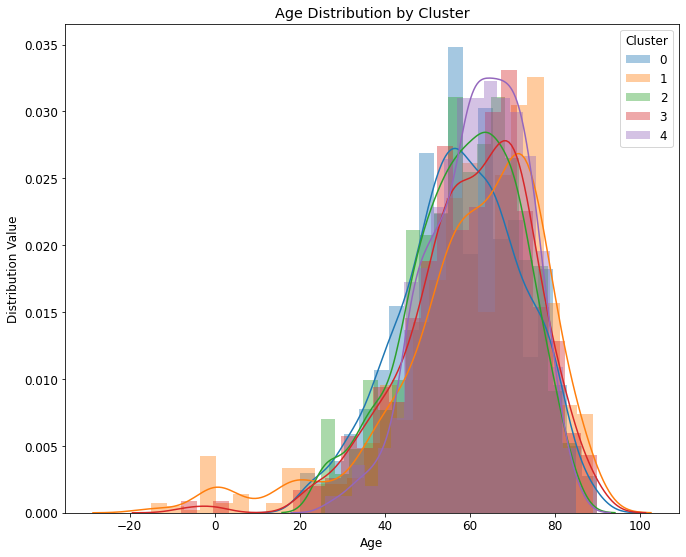

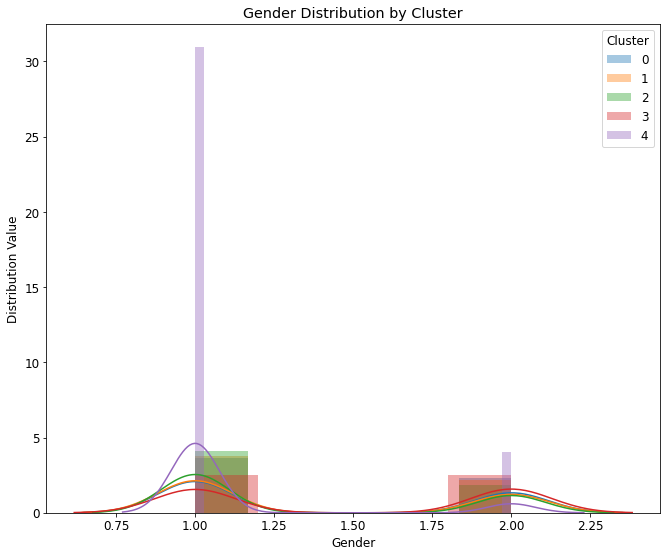

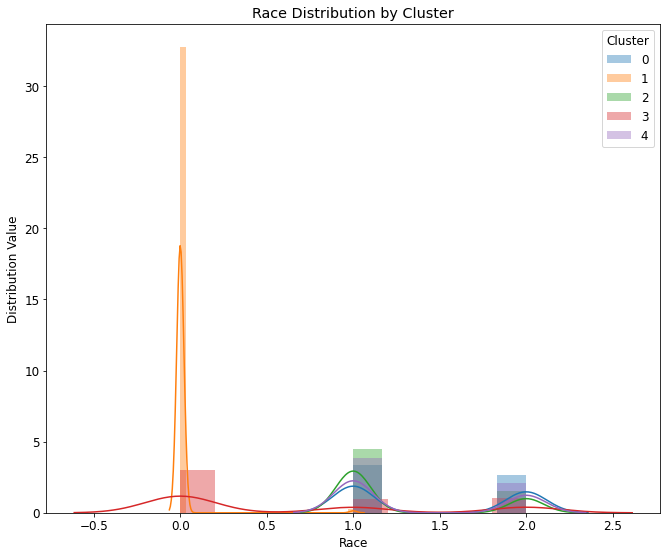

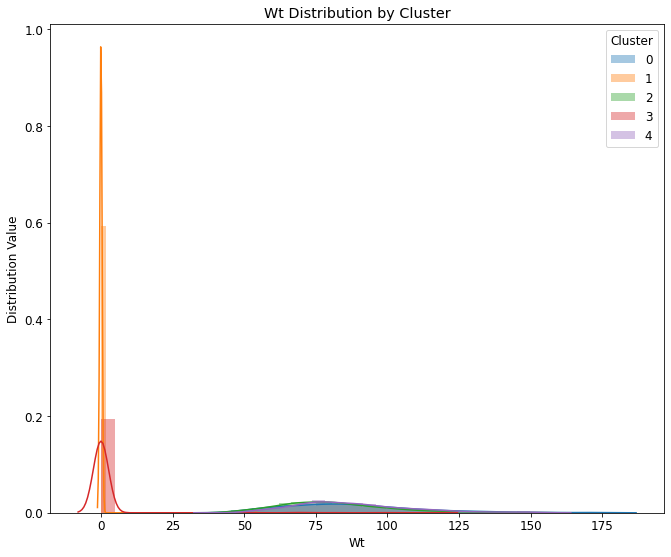

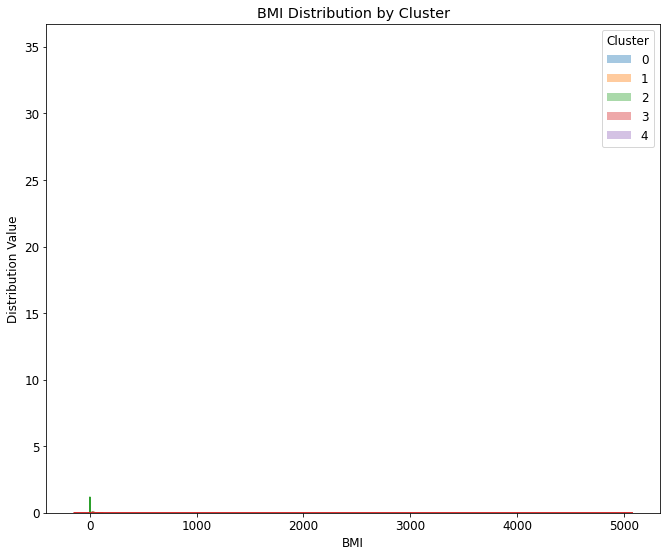

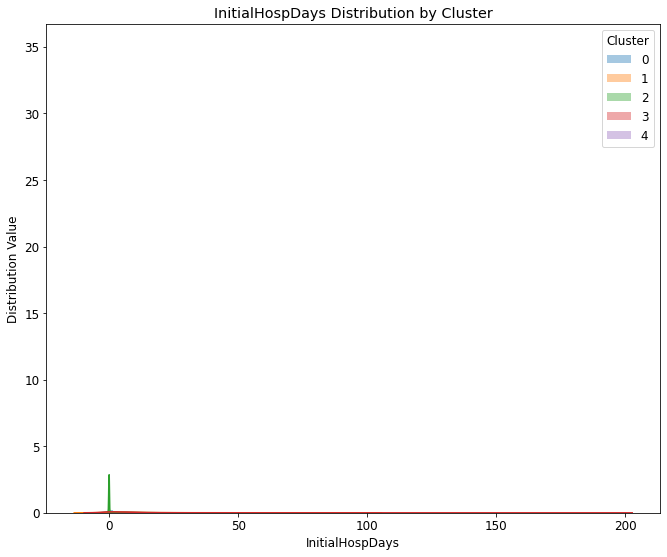

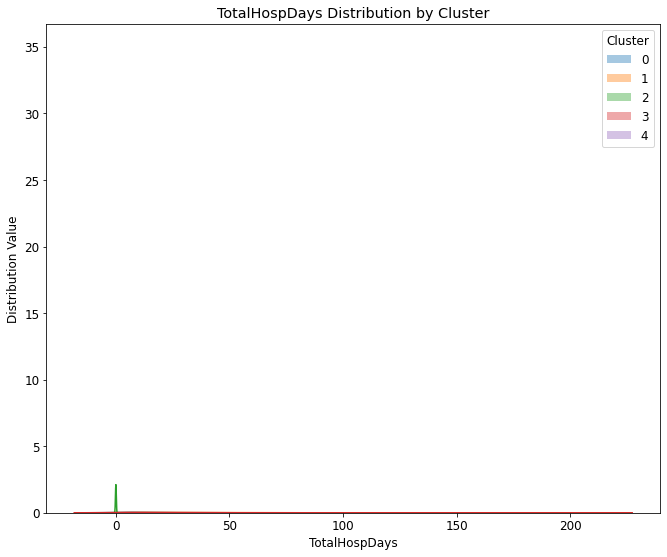

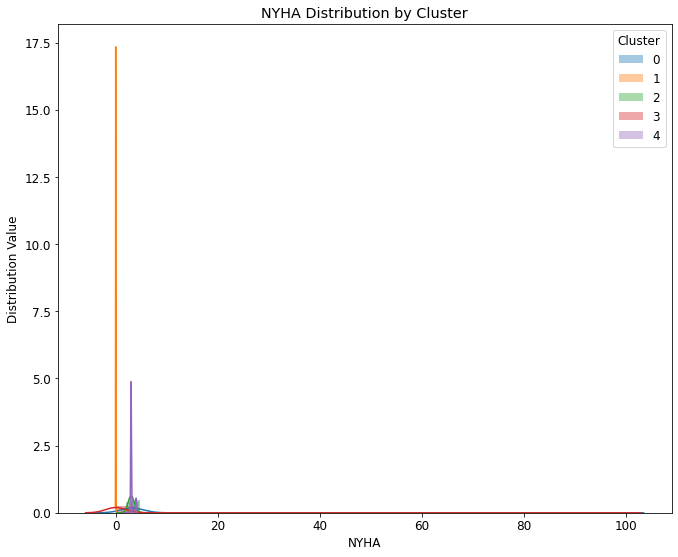

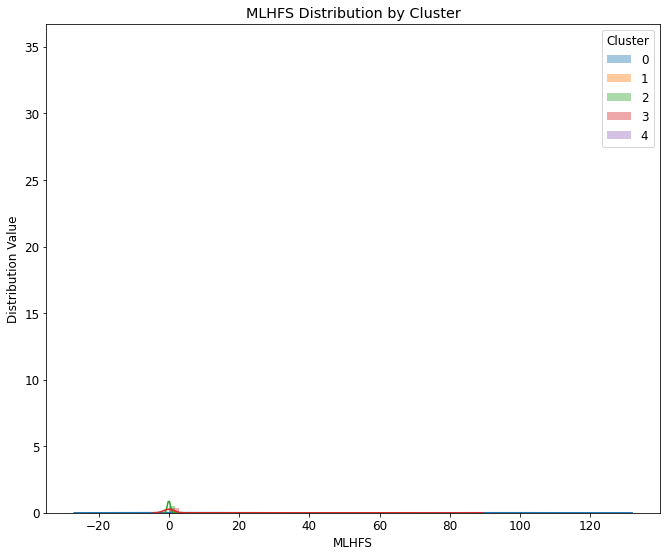

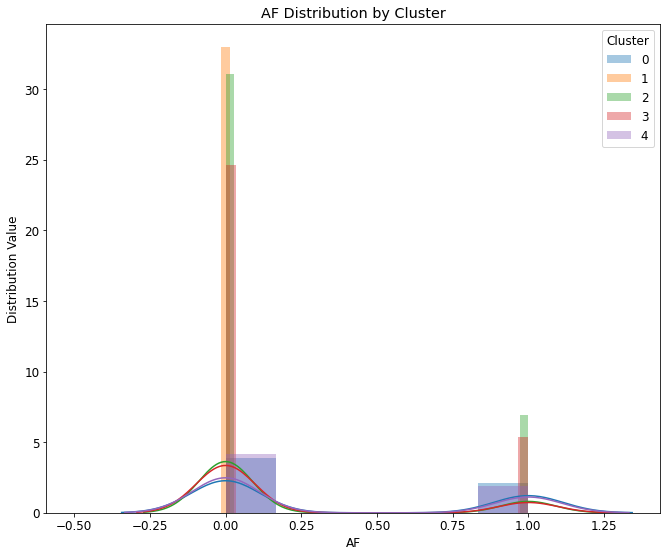

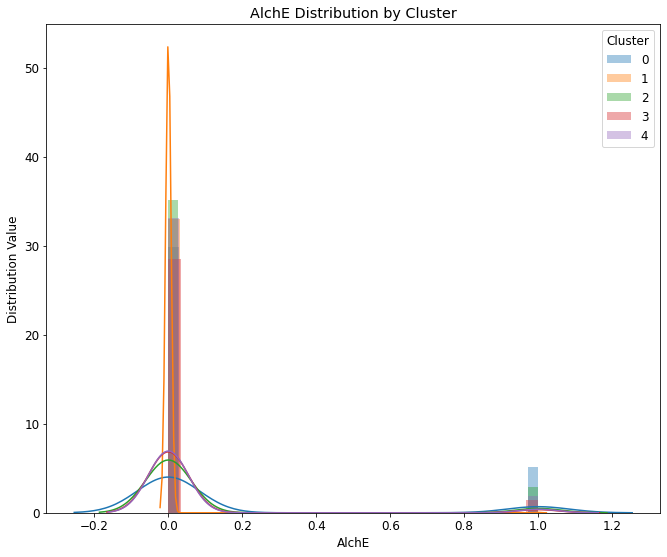

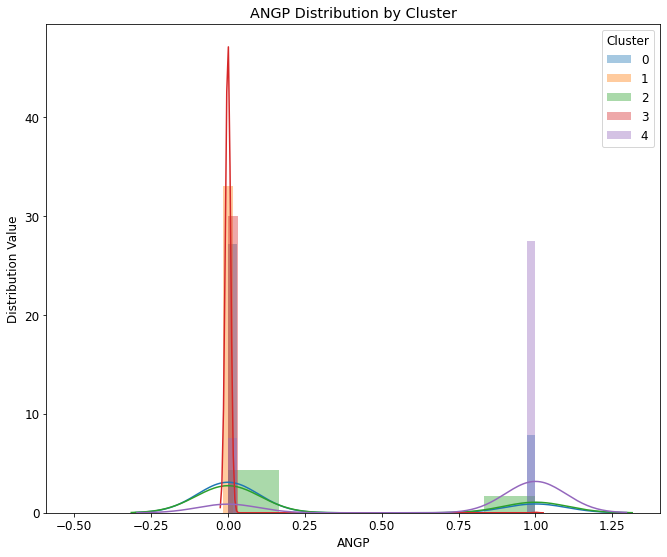

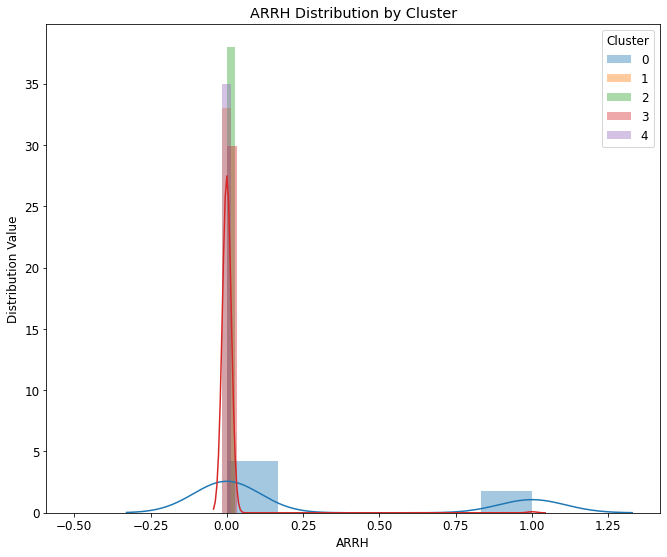

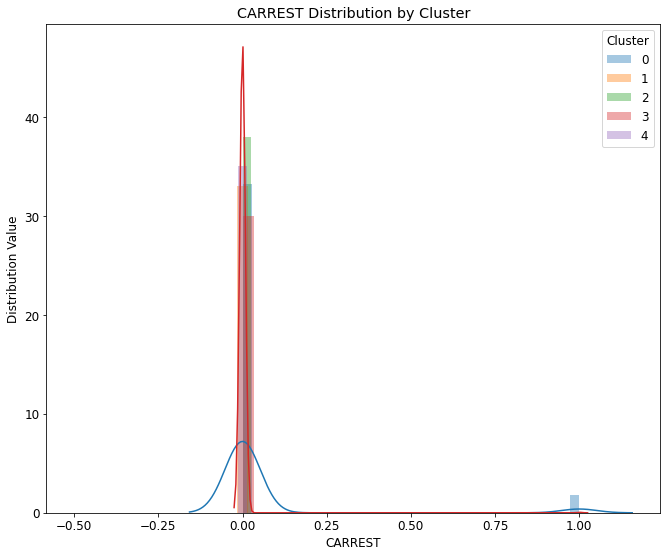

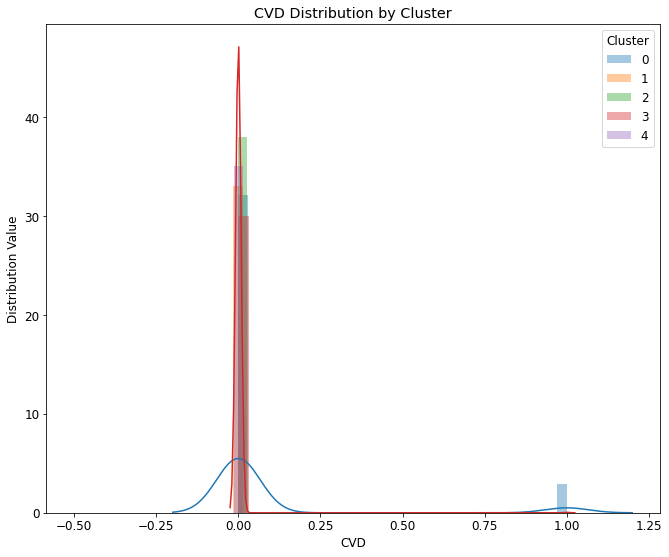

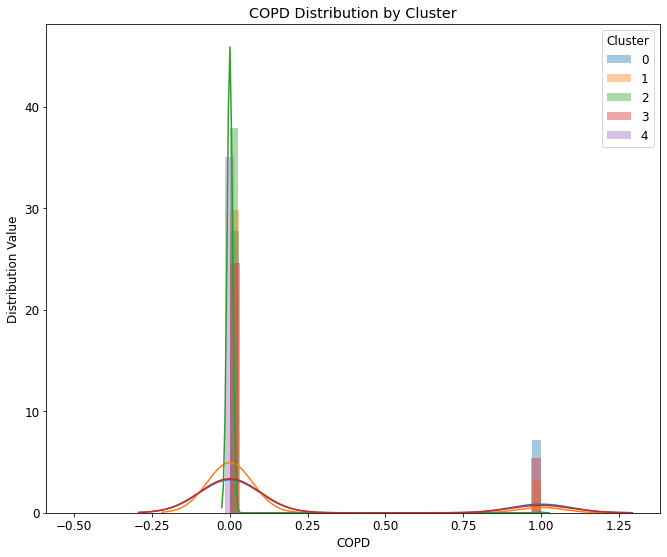

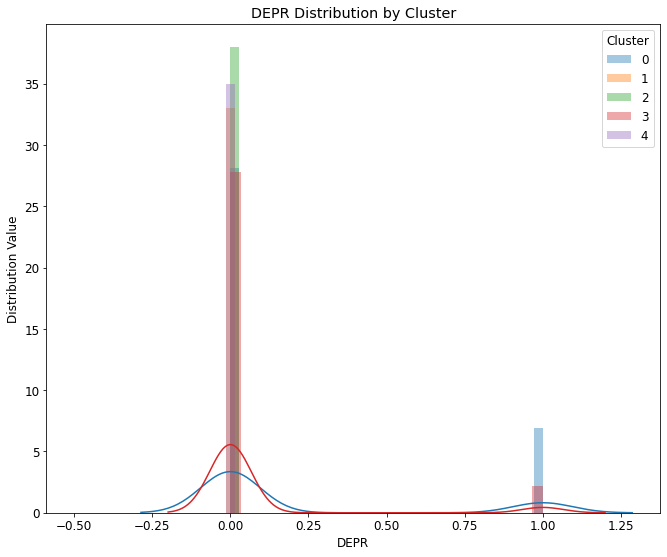

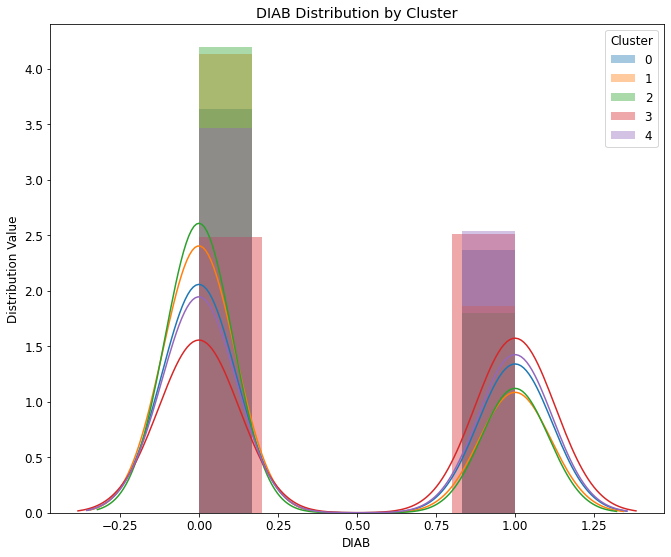

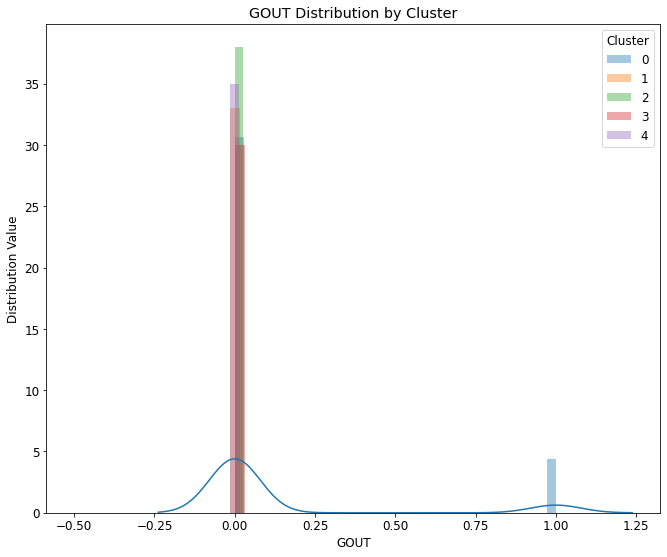

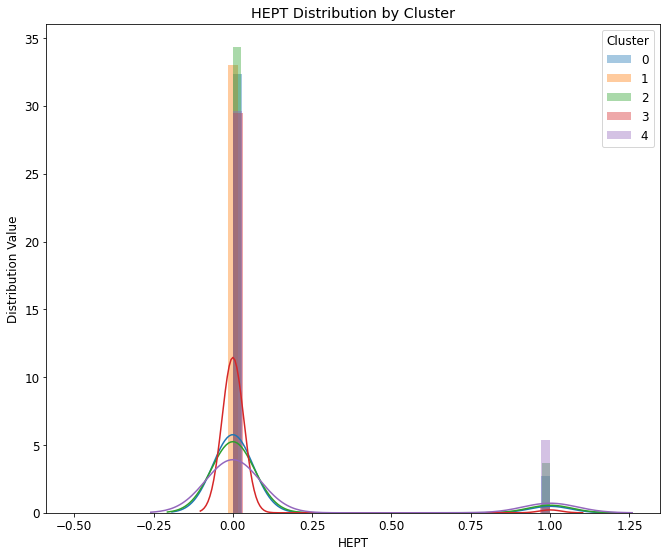

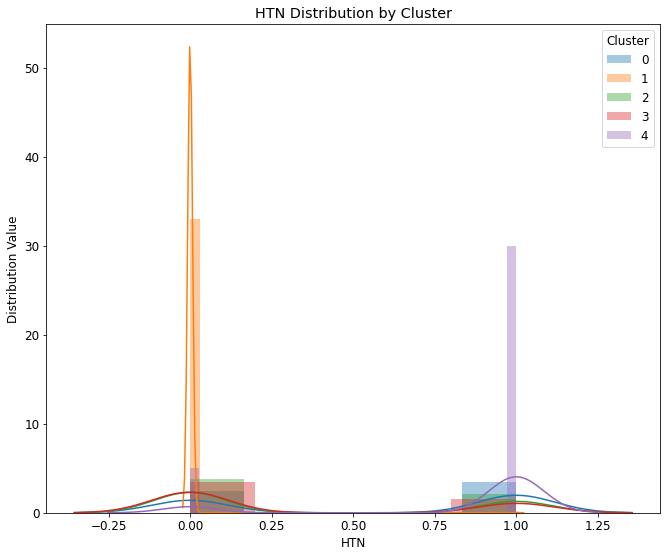

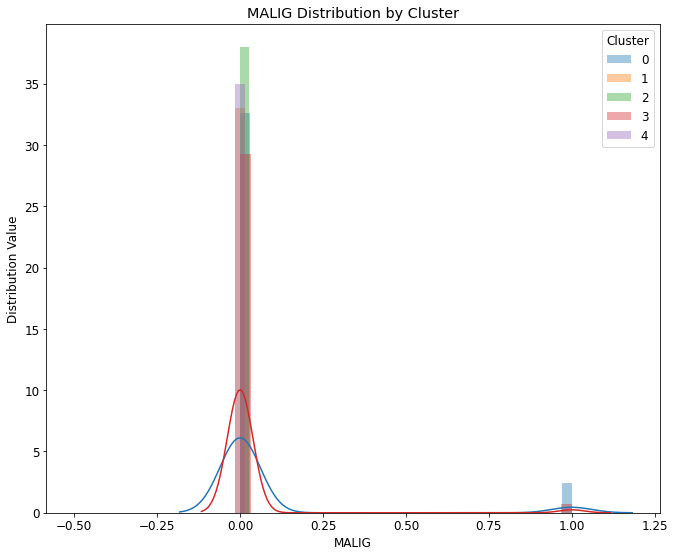

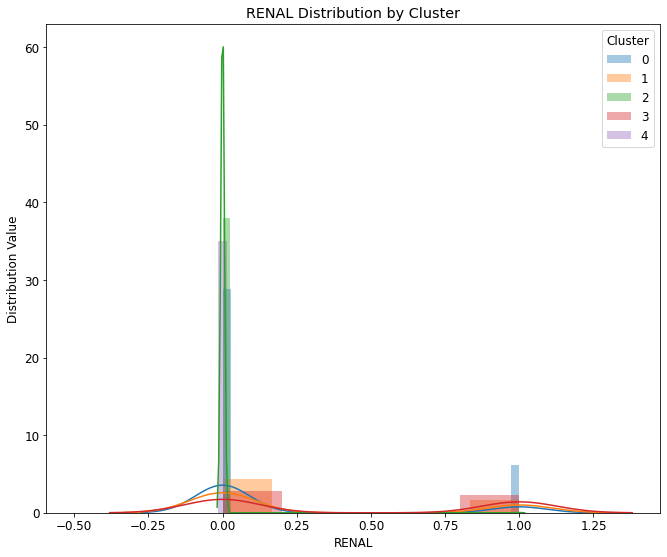

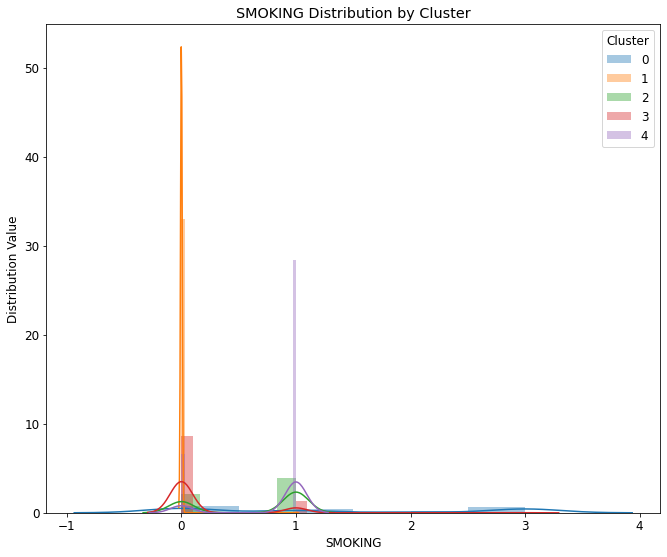

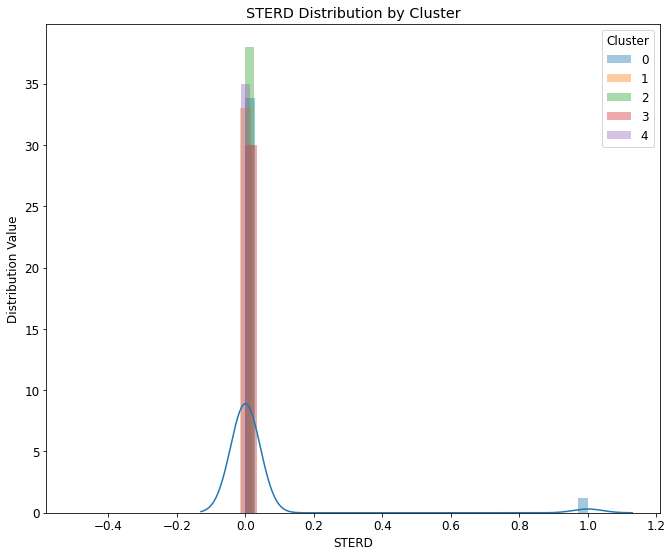

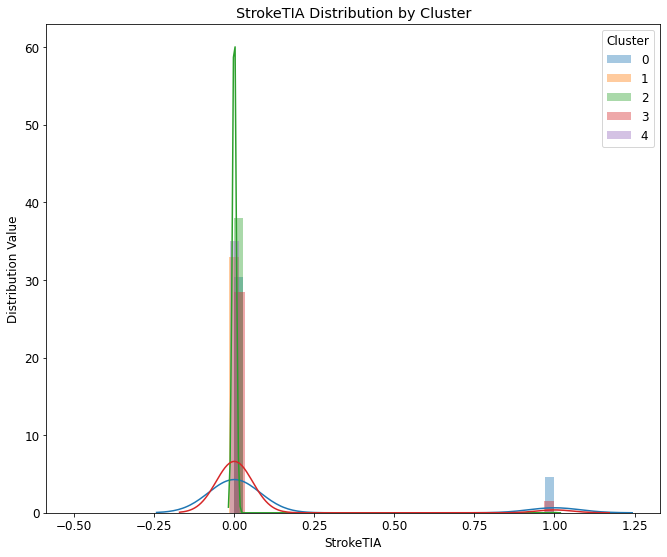

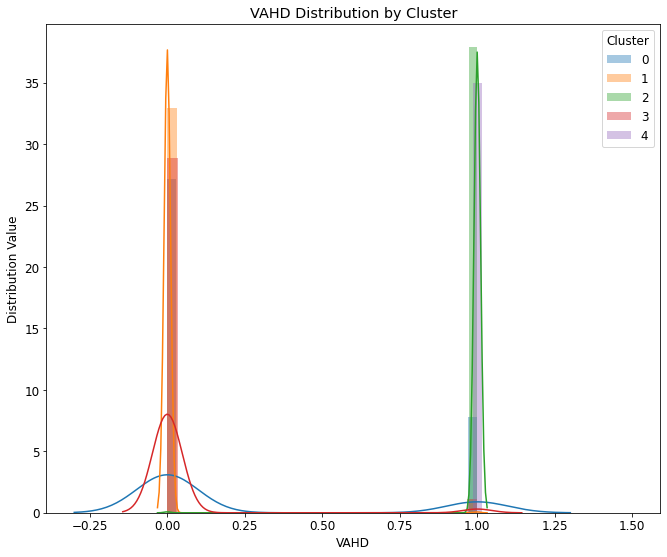

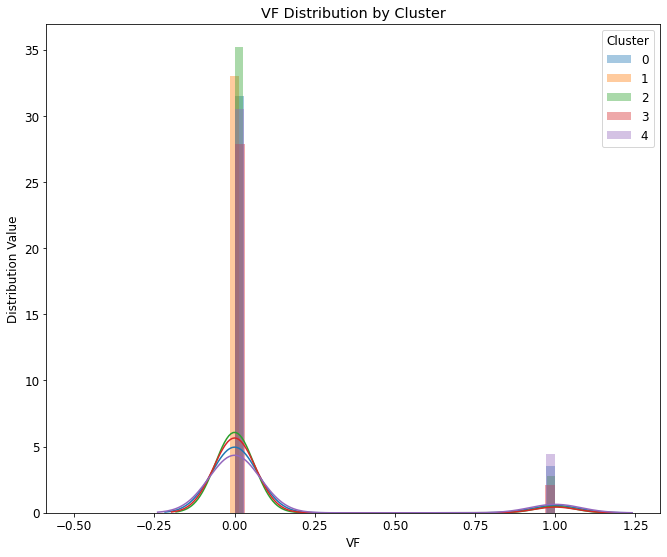

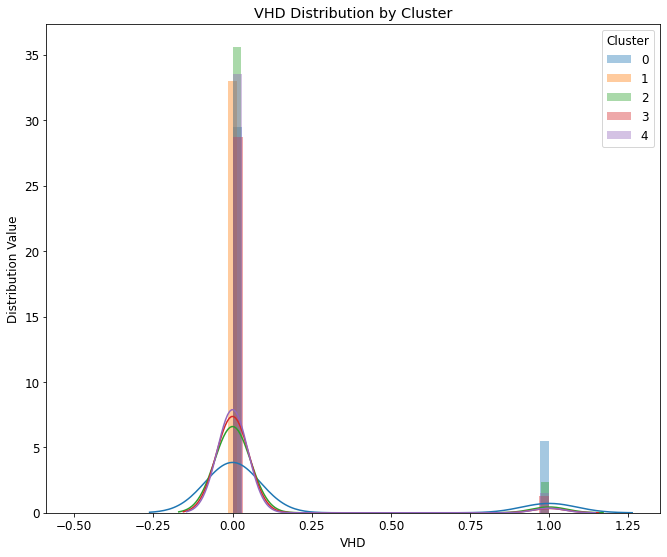

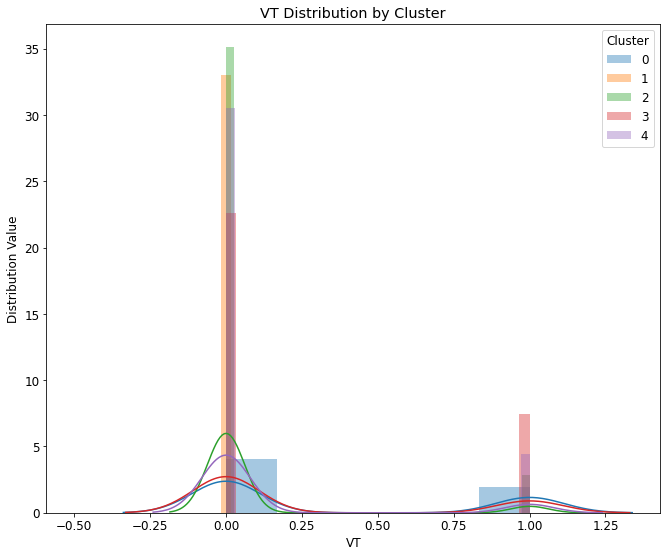

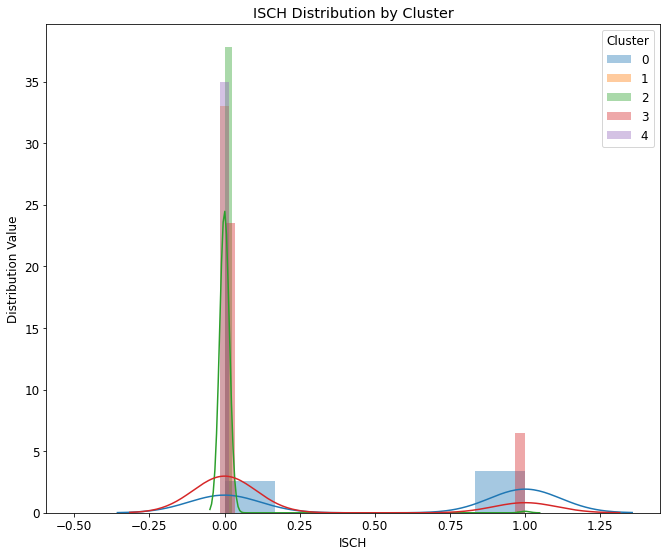

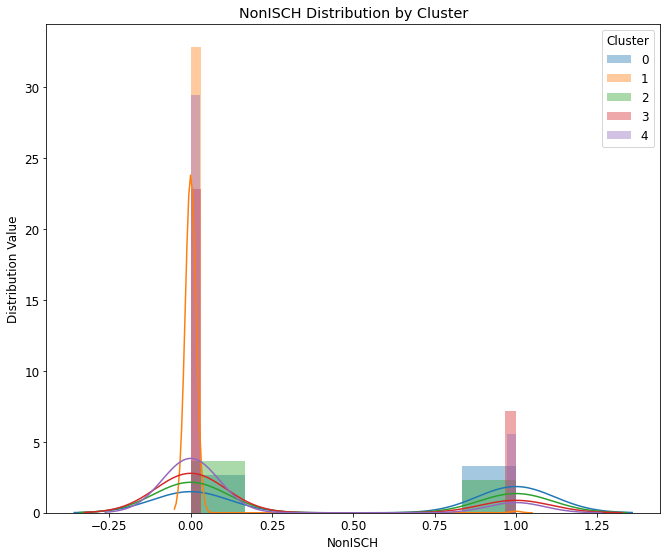

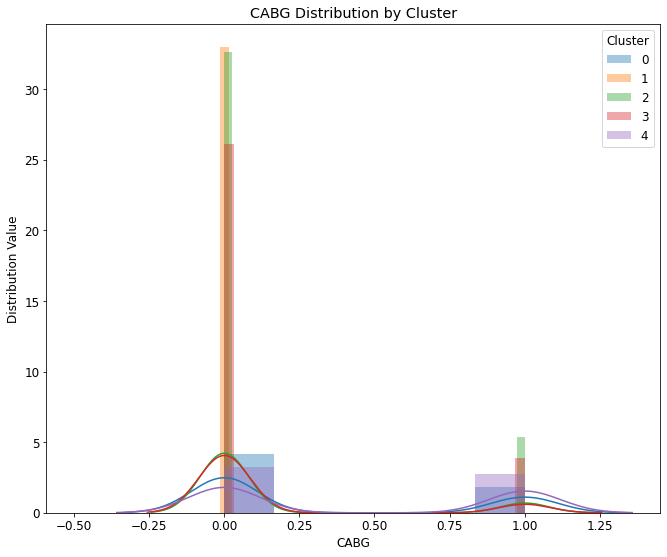

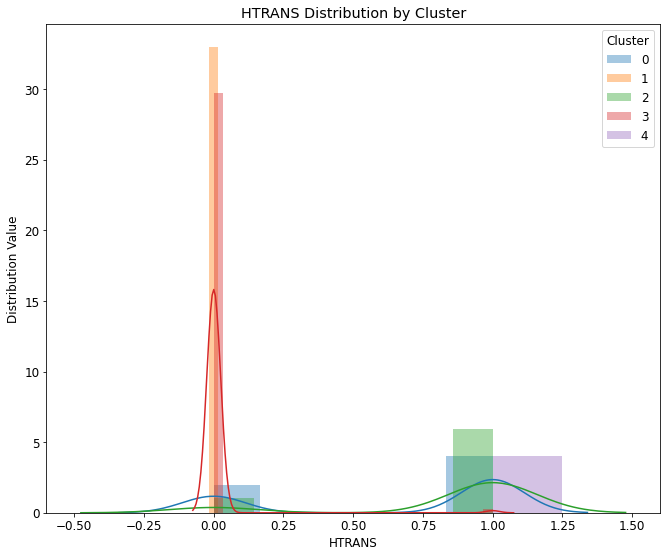

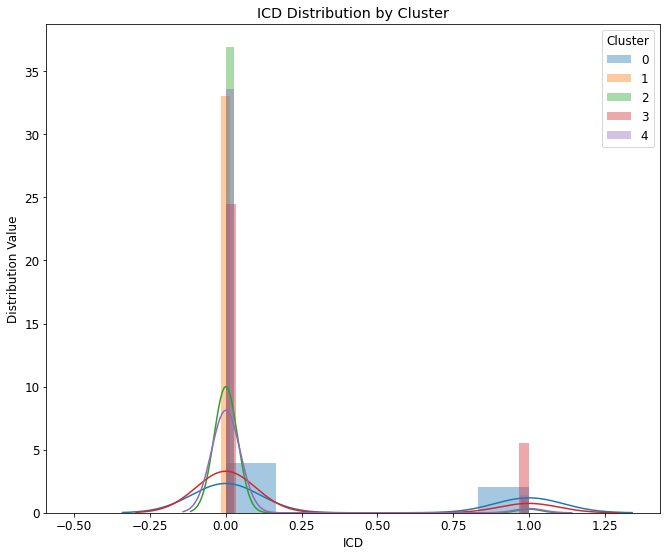

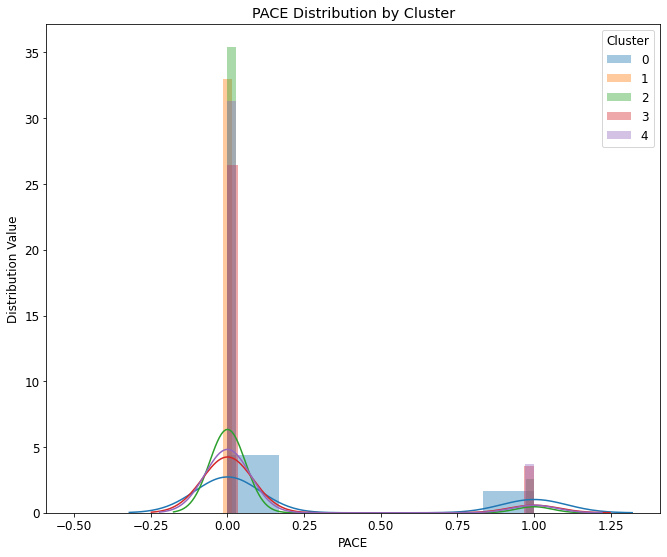

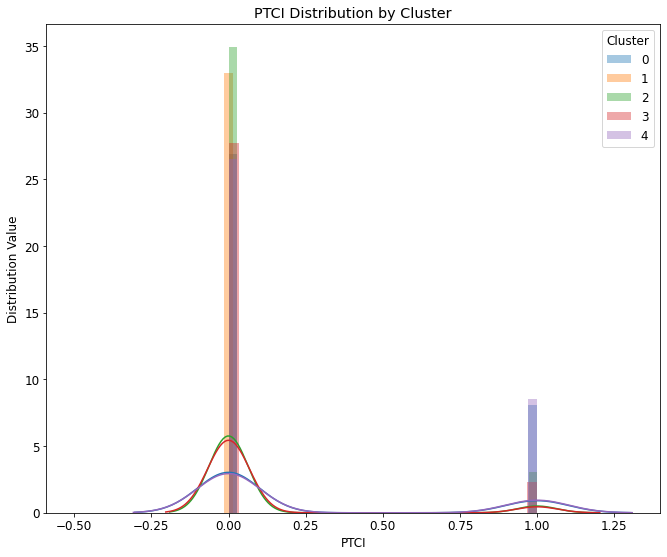

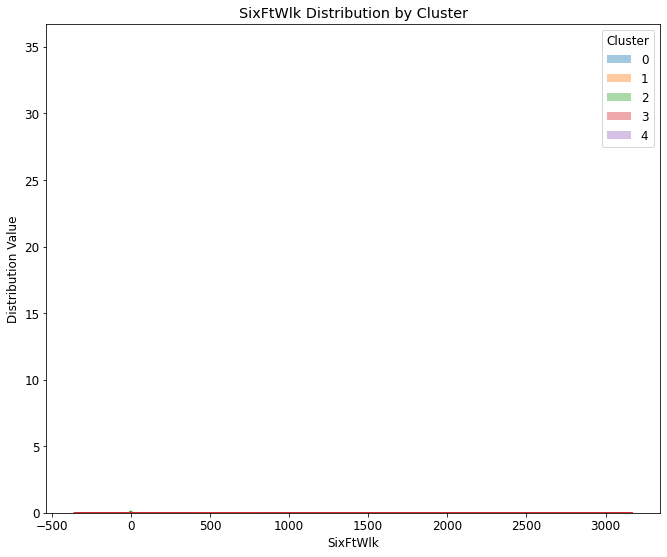

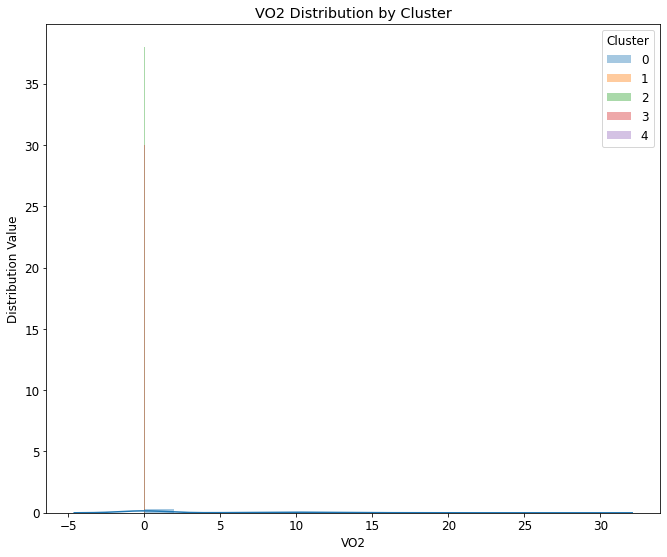

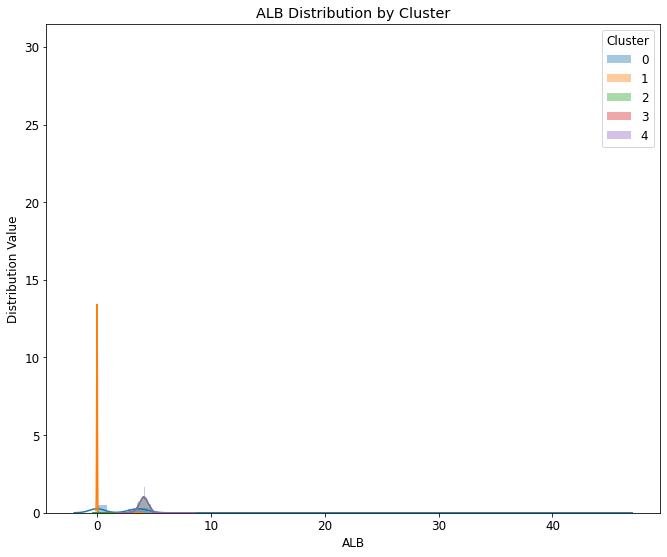

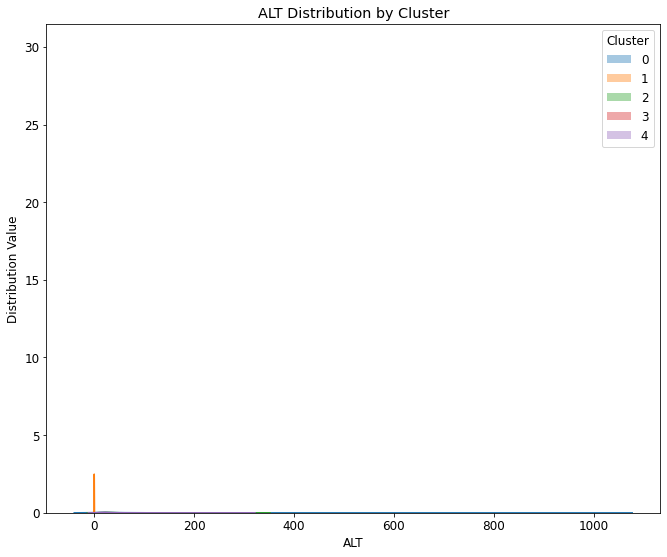

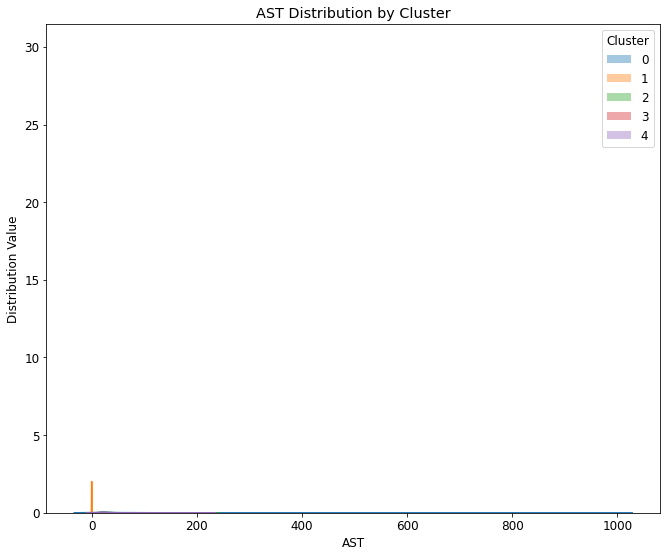

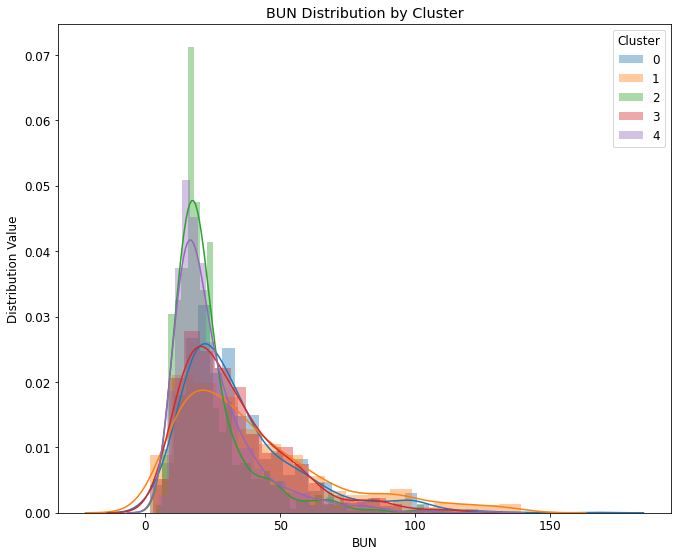

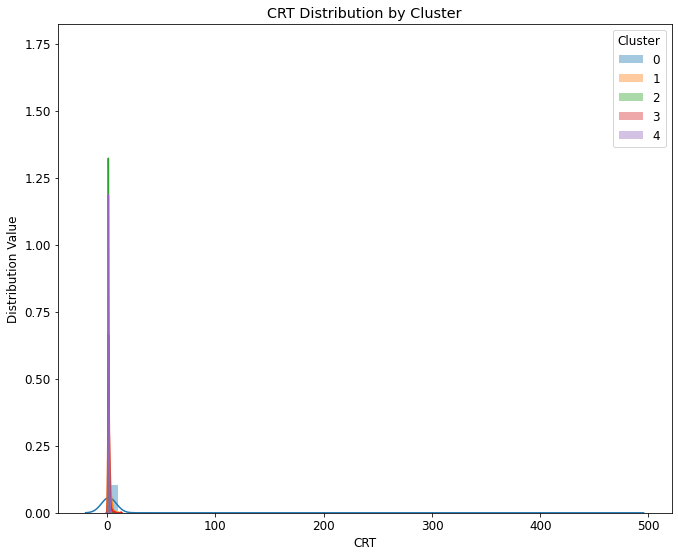

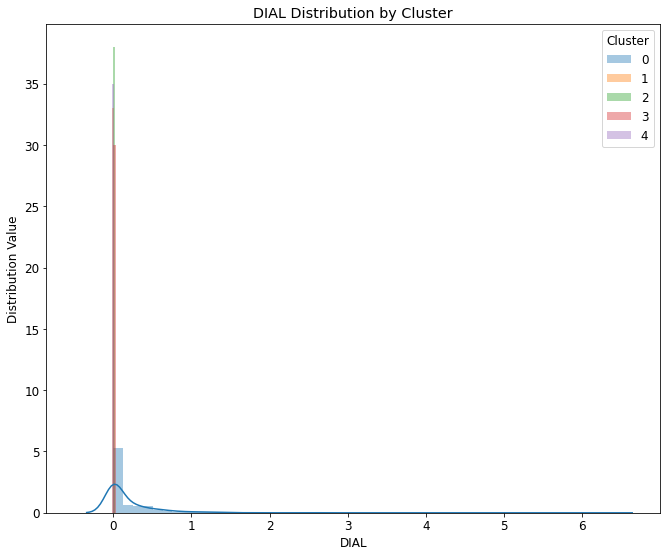

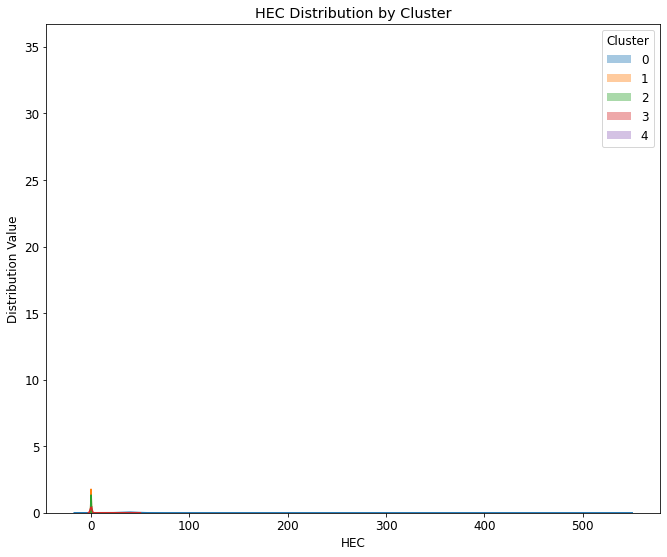

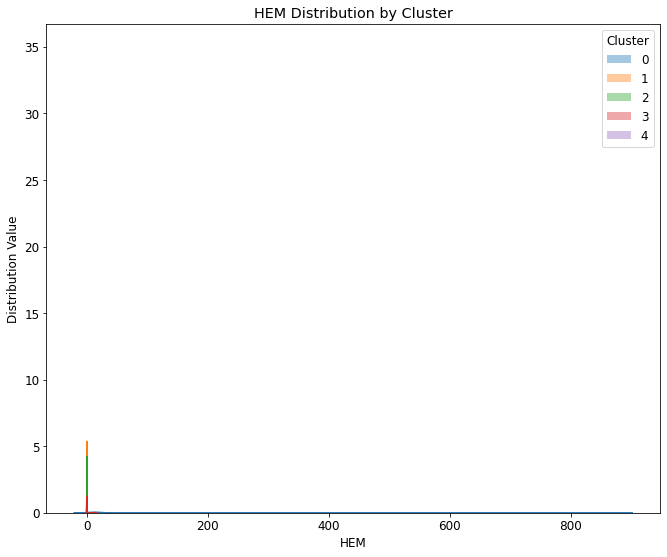

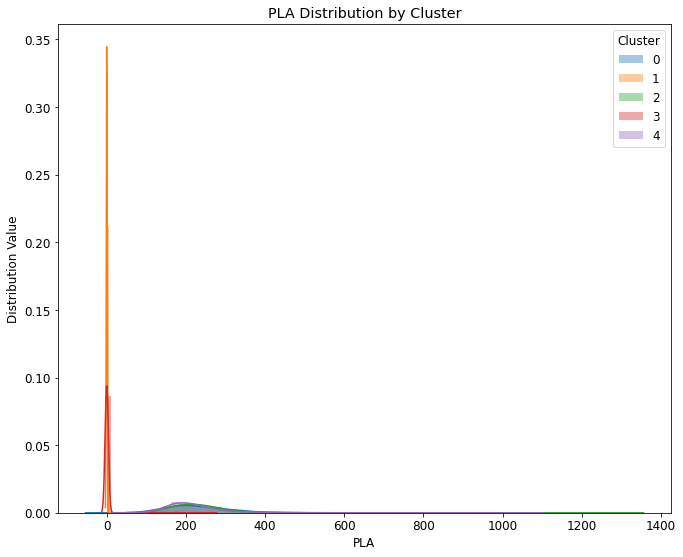

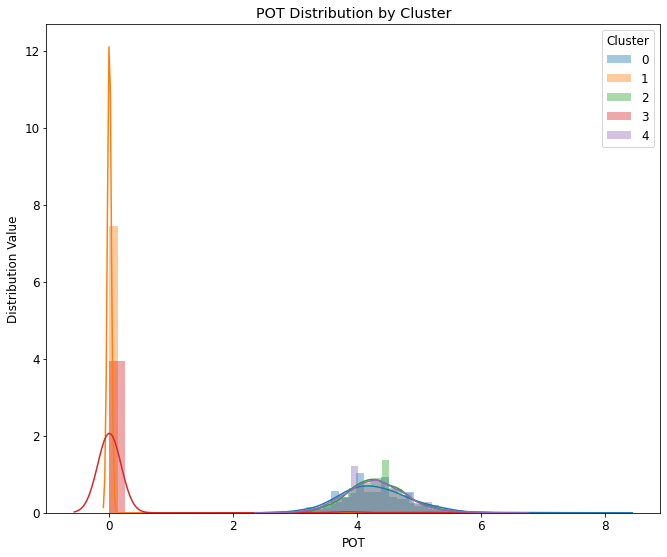

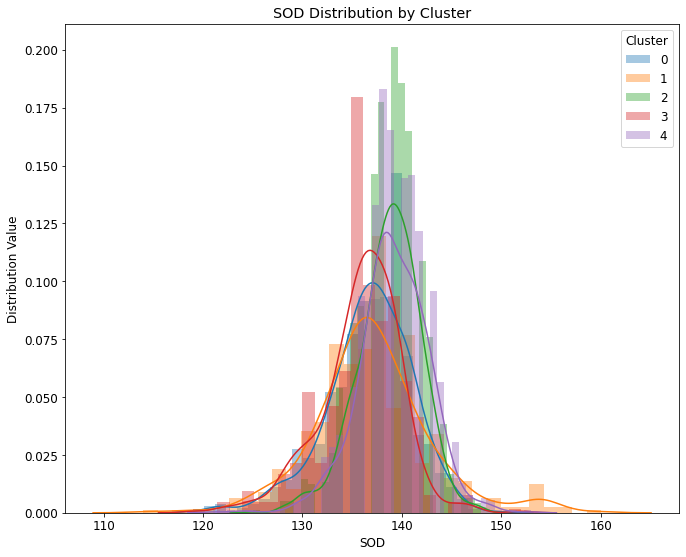

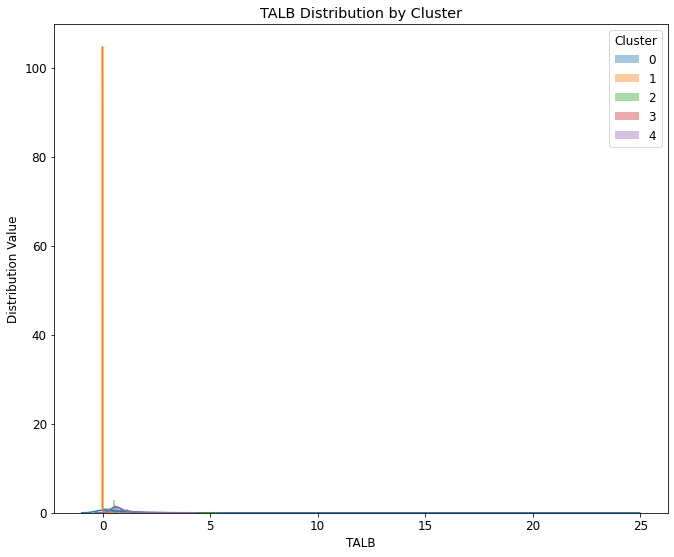

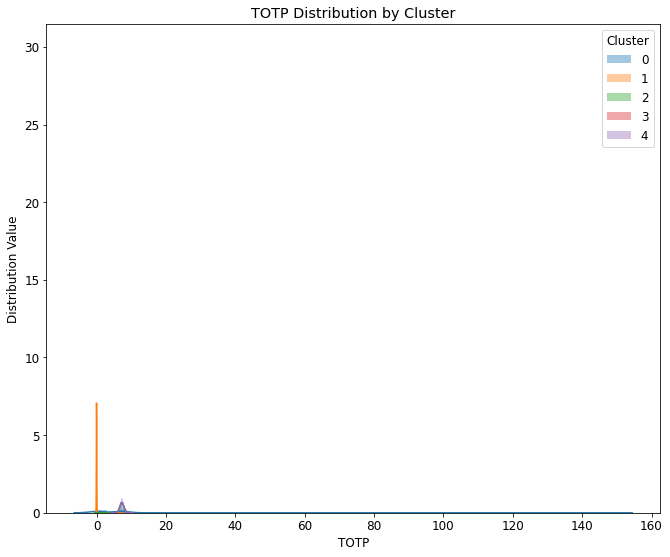

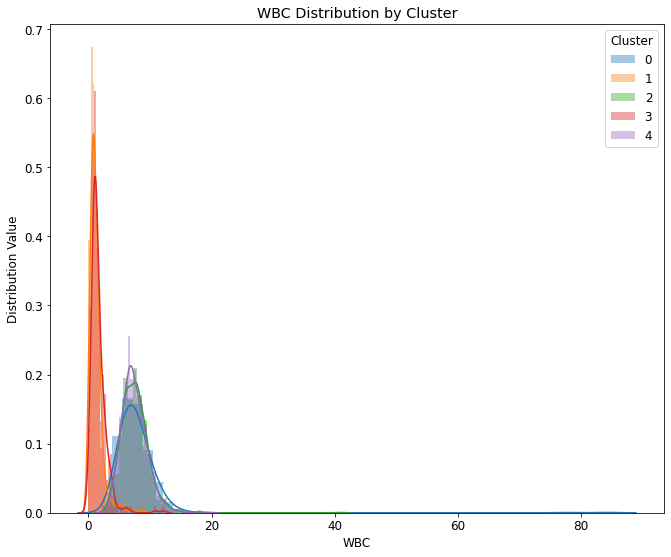

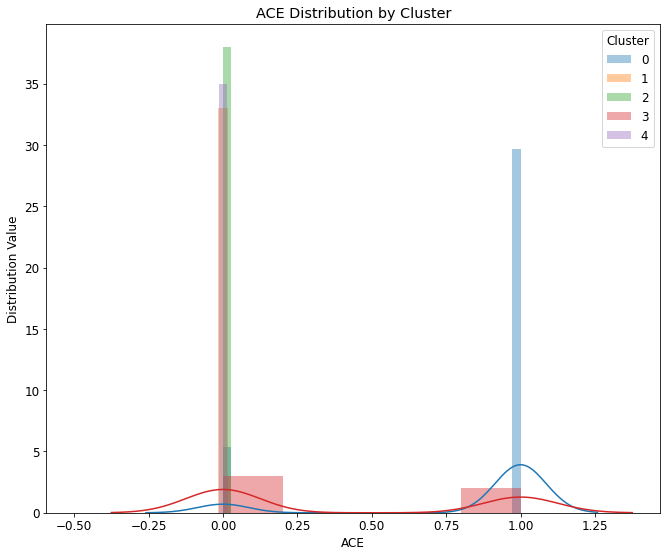

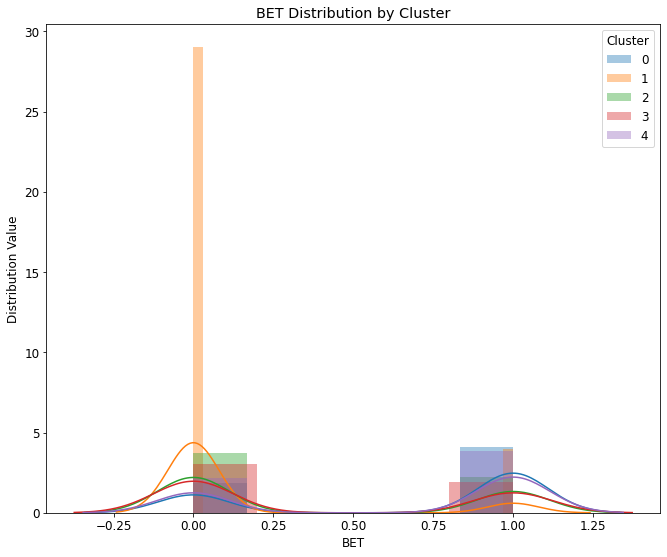

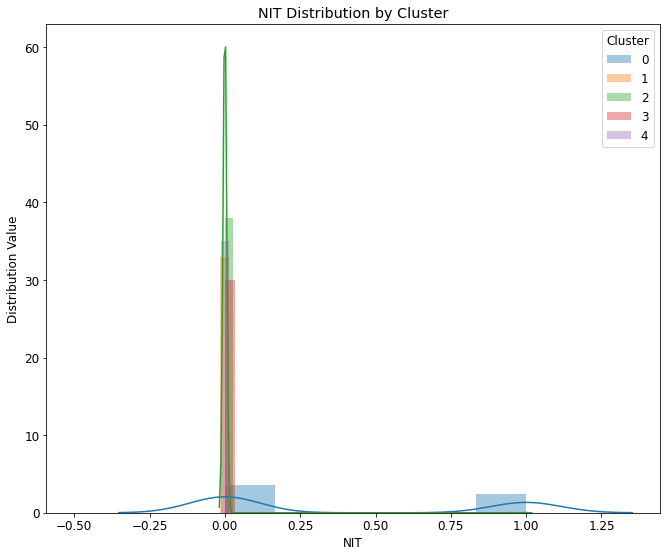

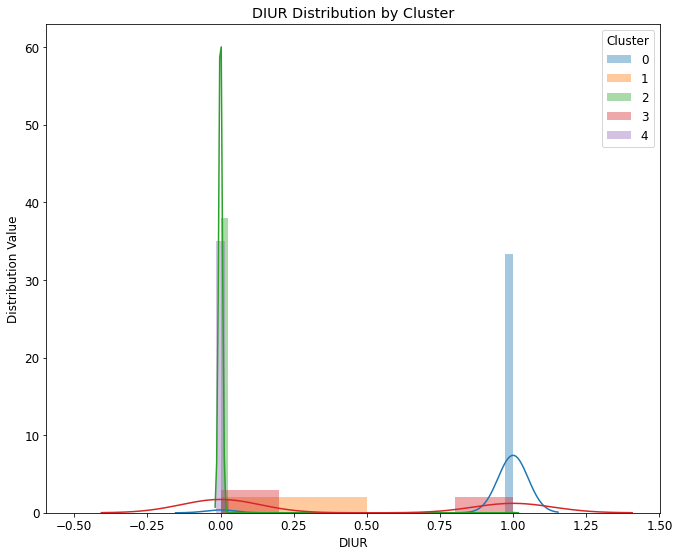

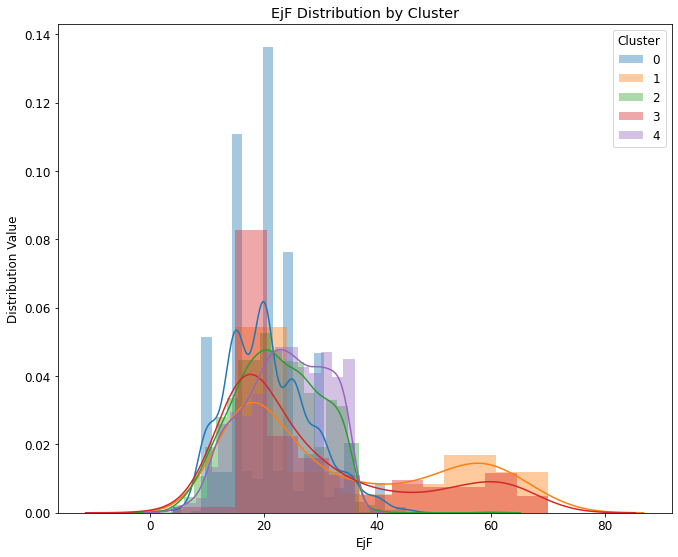

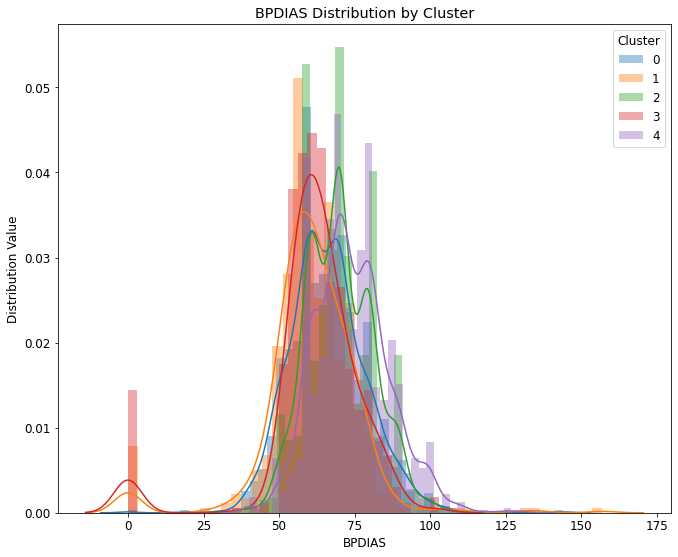

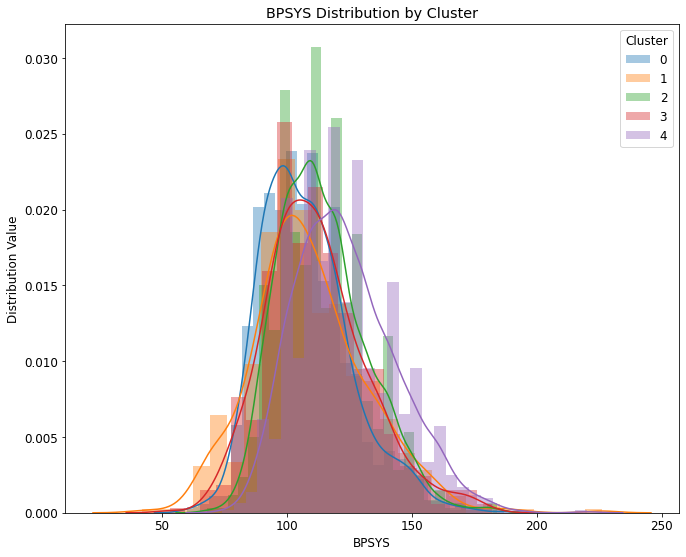

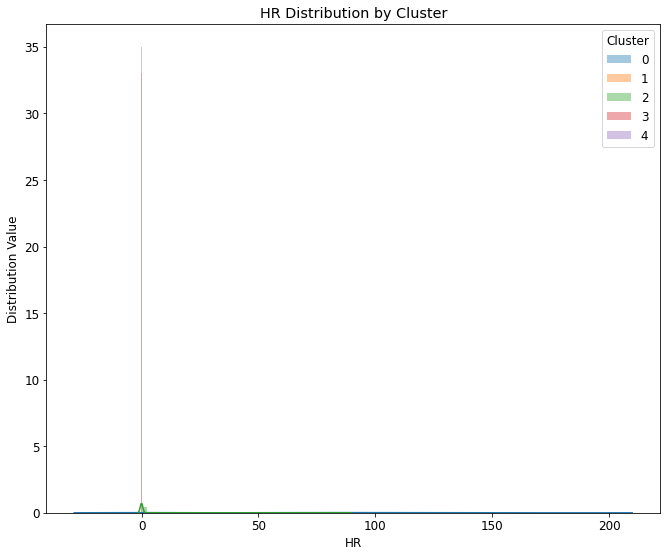

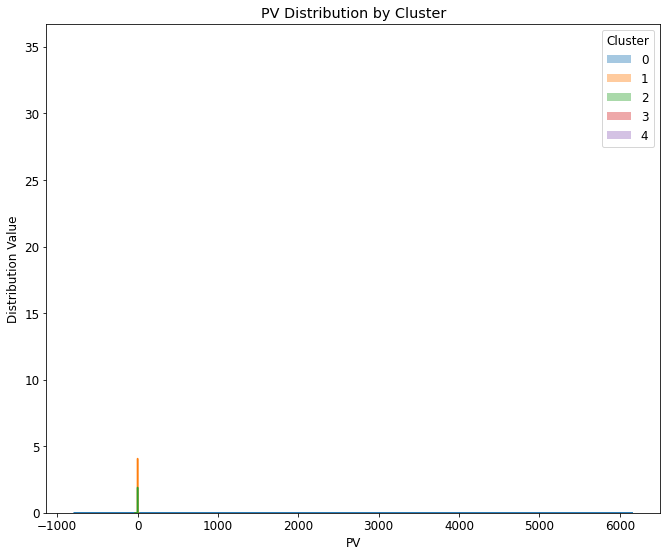

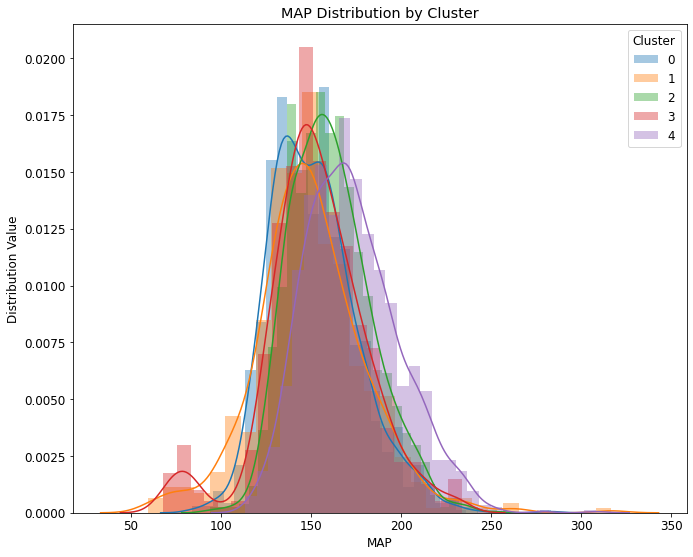

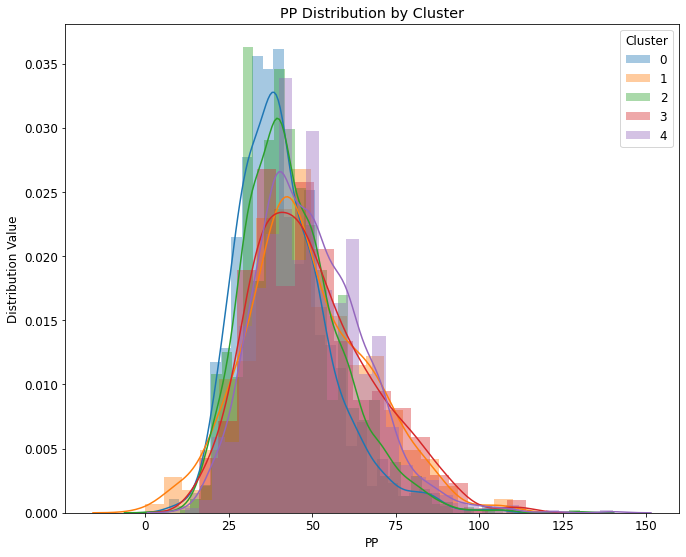

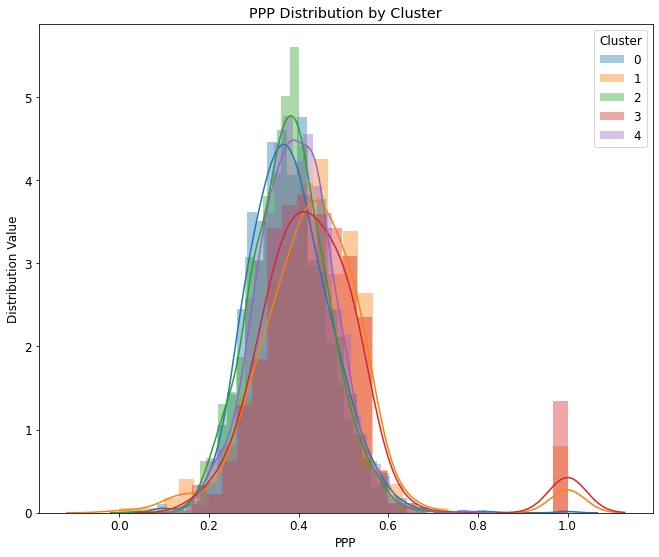

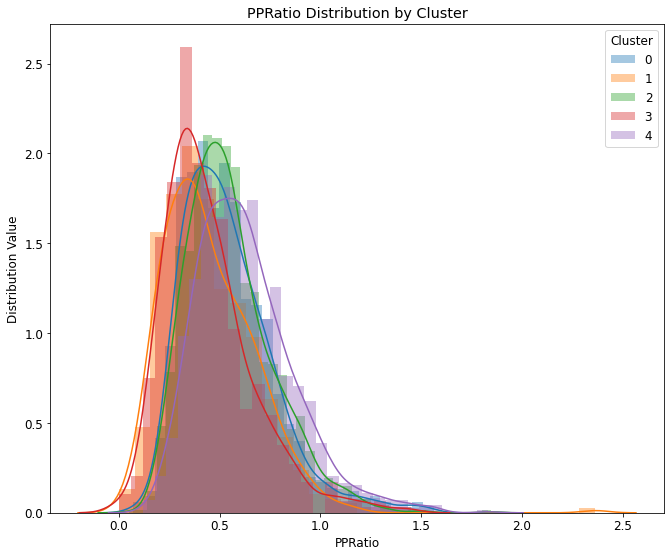

In [33]:
colss = ['Age', 'Gender', 'Race', 'Wt', 'BMI', 'InitialHospDays',
       'TotalHospDays', 'NYHA', 'MLHFS', 'AF', 'AlchE', 'ANGP', 'ARRH',
       'CARREST', 'CVD', 'COPD', 'DEPR', 'DIAB', 'GOUT', 'HEPT', 'HTN',
       'MALIG', 'RENAL', 'SMOKING', 'STERD', 'StrokeTIA', 'VAHD', 'VF', 'VHD',
       'VT', 'ISCH', 'NonISCH', 'CABG', 'HTRANS', 'ICD', 'PACE', 'PTCI',
       'SixFtWlk', 'VO2', 'ALB', 'ALT', 'AST', 'BUN', 'CRT', 'DIAL', 'HEC',
       'HEM', 'PLA', 'POT', 'SOD', 'TALB', 'TOTP', 'WBC', 'ACE', 'BET', 'NIT',
       'DIUR', 'EjF', 'BPDIAS', 'BPSYS', 'HR', 'PV', 'MAP', 'PP', 'PPP',
       'PPRatio']

distPlotsForClusters(cls=clusters, cols=colss, name="All Data")

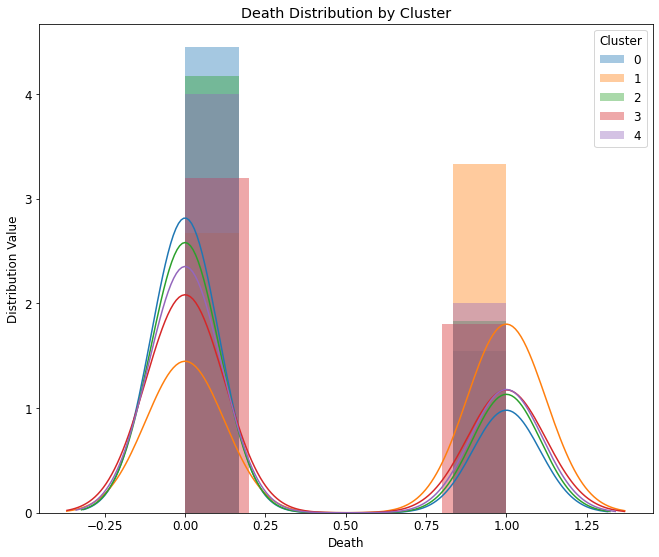

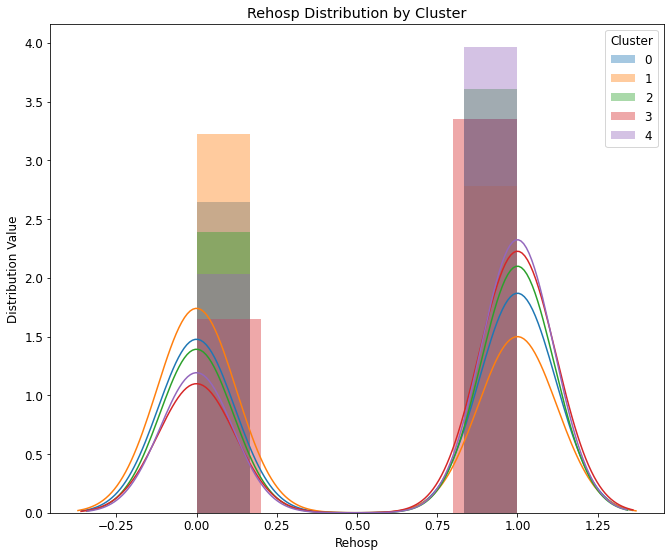

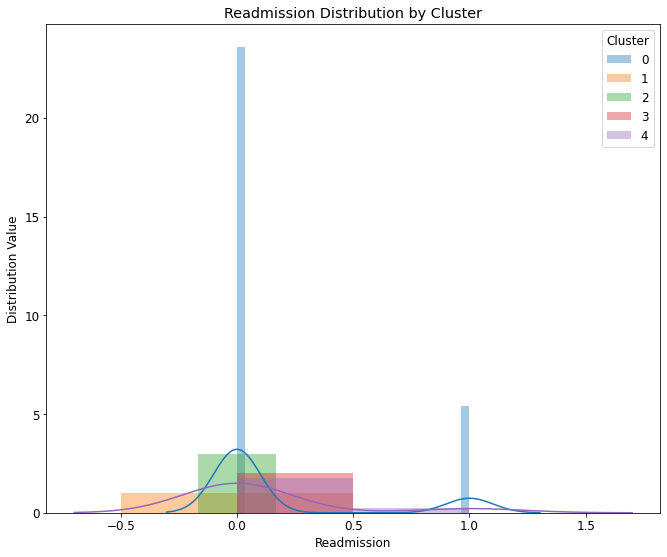

In [34]:
colss= ['Death', 'Rehosp', 'Readmission']
distPlotsForClusters(cls=clusters, cols=colss, name="All Data")

In [35]:
#Save separate datasets
escIndx = sorted(list(set(escapeAllData.index)))
escH = allDataDF.loc[escIndx,:]

escH = saveClusteredData(escH, scoreAsmts,"Data/Preprocessed Data/ESCAPE_AllData.csv")
escH

Age  Gender  Race          Wt        BMI  InitialHospDays  \
ID                                                                    
72.0     88.0     2.0   1.0   57.100000  26.424175              9.0   
72.0     88.0     2.0   1.0   52.000000  24.064047              9.0   
72.0     37.0     2.0   2.0   64.863709   0.000000              0.0   
81.0     69.0     1.0   1.0  102.363636  32.307675              5.0   
81.0     69.0     1.0   1.0  100.454545  31.705134              5.0   
...       ...     ...   ...         ...        ...              ...   
99302.0  41.0     1.0   2.0   97.400000  40.541103             21.0   
99912.0  46.0     1.0   1.0   78.636364  25.677180              2.0   
99912.0  46.0     1.0   1.0   78.200000  25.534694              2.0   
99935.0  64.0     2.0   1.0   77.700000  32.762692              3.0   
99935.0  64.0     2.0   1.0         NaN        NaN              3.0   

         TotalHospDays  NYHA  MLHFS   AF  ...     HR         PV         MAP  \
ID                                        ...                                 
72.0              16.0   4.0   76.0  1.0  ...  104.0  12.452563  139.333333   
72.0              16.0   3.0   76.0  1.0  ...   92.0  12.452563  126.000000   
72.0               0.0   3.0    0.0  1.0  ...    0.0   0.000000  118.000000   
81.0              13.0   4.0   21.0  1.0  ...   70.0  -3.346568  125.333333   
81.0              13.0   2.0   21.0  1.0  ...   72.0  -3.346568  105.666667   
...                ...   ...    ...  ...  ...    ...        ...         ...   
99302.0           21.0   NaN   79.0  0.0  ...   75.0  25.535155  130.000000   
99912.0            2.0   4.0   89.0  0.0  ...   67.0 -13.911732  174.666667   
99912.0            2.0   3.0   89.0  0.0  ...   60.0 -13.911732  140.666667   
99935.0           16.0   3.0  101.0  0.0  ...   86.0        NaN  135.333333   
99935.0           16.0   NaN  101.0  0.0  ...   87.0        NaN  153.333333   

           PP       PPP   PPRatio  Score  ScoreDeath  ScoreRehosp  \
ID                                                                  
72.0     26.0  0.276596  0.250000      3           1            2   
72.0     26.0  0.302326  0.282609      3           1            2   
72.0     28.0  0.341463  0.411765      1           2            3   
81.0     32.0  0.363636  0.457143      3           1            2   
81.0     34.0  0.441558  0.472222      3           1            2   
...       ...       ...       ...    ...         ...          ...   
99302.0  55.0  0.550000  0.733333      3           1            2   
99912.0  38.0  0.316667  0.567164      3           1            2   
99912.0  24.0  0.255319  0.400000      3           1            2   
99935.0  42.0  0.428571  0.488372      3           1            2   
99935.0  70.0  0.583333  0.804598      3           1            2   

         ScoreReadmission  
ID                         
72.0                    5  
72.0                    5  
72.0                    2  
81.0                    5  
81.0                    5  
...                   ...  
99302.0                 5  
99912.0                 5  
99912.0                 5  
99935.0                 5  
99935.0                 5  

[887 rows x 70 columns]

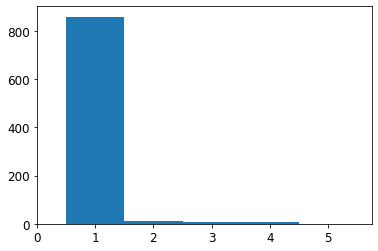

In [36]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(escH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

In [37]:
guIndx = sorted(list(set(guideAllData.index)))
guH = allDataDF.loc[guIndx,:]

guH = saveClusteredData(guH, scoreAsmts,"Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AllData.csv")
guH

Age  Gender  Race          Wt        BMI  InitialHospDays  \
ID                                                                    
11.0     77.0     1.0   1.0   74.389149   0.000000              0.0   
11.0     57.0     2.0   2.0   88.905017  33.643189              0.0   
11.0     57.0     2.0   2.0   91.172066   0.000000              0.0   
615.0    59.0     1.0   1.0   75.296333   0.000000              0.0   
615.0    70.0     2.0   2.0   87.500000  34.179688              0.0   
...       ...     ...   ...         ...        ...              ...   
98788.0  56.0     1.0   2.0         NaN   0.000000              0.0   
99329.0  33.0     1.0   2.0  142.400000  52.241316              0.0   
99329.0  33.0     1.0   2.0         NaN   0.000000              0.0   
99355.0  46.0     2.0   2.0   75.750703  23.379847              0.0   
99355.0  46.0     2.0   2.0         NaN   0.000000              0.0   

         TotalHospDays  NYHA  MLHFS   AF  ...   HR   PV         MAP    PP  \
ID                                        ...                               
11.0               0.0   3.0    0.0  1.0  ...  0.0  0.0  165.333333  52.0   
11.0              70.0   3.0    0.0  0.0  ...  0.0  0.0  148.000000  33.0   
11.0              70.0   3.0    0.0  0.0  ...  0.0  0.0  147.000000  32.0   
615.0              0.0   3.0    0.0  0.0  ...  0.0  0.0  169.333333  36.0   
615.0              0.0   3.0    0.0  0.0  ...  0.0  0.0  184.000000  54.0   
...                ...   ...    ...  ...  ...  ...  ...         ...   ...   
98788.0            3.0   NaN    0.0  1.0  ...  0.0  0.0         NaN   NaN   
99329.0           30.0   3.0    0.0  0.0  ...  0.0  0.0  135.333333  32.0   
99329.0           30.0   NaN    0.0  0.0  ...  0.0  0.0         NaN   NaN   
99355.0           19.0   4.0    0.0  0.0  ...  0.0  0.0  148.333333  30.0   
99355.0           19.0   NaN    0.0  0.0  ...  0.0  0.0         NaN   NaN   

              PPP   PPRatio  Score  ScoreDeath  ScoreRehosp  ScoreReadmission  
ID                                                                             
11.0     0.433333  0.812500      4           3            4                 4  
11.0     0.323529  0.375000      3           1            2                 5  
11.0     0.316832  0.363636      3           1            2                 5  
615.0    0.310345  0.375000      1           2            3                 2  
615.0    0.409091  0.600000      3           1            2                 5  
...           ...       ...    ...         ...          ...               ...  
98788.0       NaN       NaN      5           4            5                 3  
99329.0  0.340426  0.400000      3           1            2                 5  
99329.0       NaN       NaN      5           4            5                 3  
99355.0  0.297030  0.333333      3           1            2                 5  
99355.0       NaN       NaN      5           4            5                 3  

[790 rows x 70 columns]

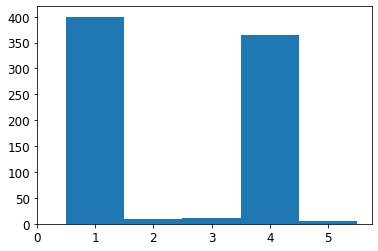

In [38]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(guH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

In [39]:
guIndx = sorted(list(set(bestAllData.index)))
guH = allDataDF.loc[guIndx,:]

guH = saveClusteredData(guH, scoreAsmts,"Data Validation/BEST/Preprocessed Data/BEST_AllData.csv")
guH

Age  Gender  Race          Wt  BMI  InitialHospDays  TotalHospDays  \
ID                                                                            
1.0     73.0     2.0   1.0   50.348753  0.0              0.0            0.0   
2.0     72.0     1.0   1.0   77.110703  0.0              0.0            0.0   
3.0     58.0     1.0   1.0   94.800805  0.0              0.0            0.0   
4.0     42.0     1.0   1.0  134.716934  0.0              0.0            0.0   
5.0     58.0     1.0   2.0   70.306817  0.0              0.0            0.0   
...      ...     ...   ...         ...  ...              ...            ...   
2704.0  60.0     1.0   1.0   86.182550  0.0              0.0            0.0   
2705.0  67.0     1.0   1.0   77.110703  0.0              0.0            0.0   
2706.0  78.0     2.0   1.0   45.812829  0.0              0.0            0.0   
2707.0  80.0     1.0   1.0   68.946040  0.0              0.0            0.0   
2708.0  38.0     2.0   1.0  116.573239  0.0              0.0            0.0   

        NYHA  MLHFS   AF  ...   HR   PV         MAP    PP       PPP   PPRatio  \
ID                        ...                                                   
1.0      3.0    0.0  0.0  ...  0.0  0.0  176.666667  60.0  0.461538  0.882353   
2.0      3.0    0.0  1.0  ...  0.0  0.0  181.666667  40.0  0.320000  0.571429   
3.0      3.0    0.0  0.0  ...  0.0  0.0  172.666667  36.0  0.305085  0.375000   
4.0      3.0    0.0  0.0  ...  0.0  0.0  201.666667  35.0  0.259259  0.555556   
5.0      4.0    0.0  0.0  ...  0.0  0.0  180.333333  62.0  0.466165  0.873239   
...      ...    ...  ...  ...  ...  ...         ...   ...       ...       ...   
2704.0   3.0    0.0  0.0  ...  0.0  0.0  133.333333  25.0  0.277778  0.403226   
2705.0   3.0    0.0  0.0  ...  0.0  0.0  220.000000  70.0  0.437500  0.921053   
2706.0   3.0    0.0  0.0  ...  0.0  0.0  160.666667  54.0  0.457627  0.750000   
2707.0   3.0    0.0  1.0  ...  0.0  0.0  153.333333  45.0  0.409091  0.625000   
2708.0   3.0    0.0  0.0  ...  0.0  0.0  146.666667  30.0  0.300000  0.306122   

        Score  ScoreDeath  ScoreRehosp  ScoreReadmission  
ID                                                        
1.0         1           2            3                 2  
2.0         4           3            4                 4  
3.0         1           2            3                 2  
4.0         4           3            4                 4  
5.0         4           3            4                 4  
...       ...         ...          ...               ...  
2704.0      4           3            4                 4  
2705.0      4           3            4                 4  
2706.0      1           2            3                 2  
2707.0      4           3            4                 4  
2708.0      1           2            3                 2  

[2769 rows x 70 columns]

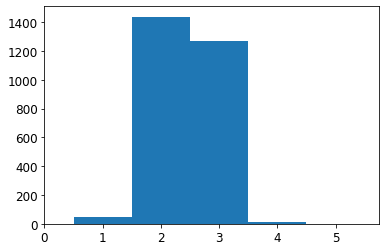

In [40]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(guH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

In [41]:
csIndx = sorted(list(set(cardShockAllData.index)))
csH = allDataDF.loc[csIndx,:]

csH = saveClusteredData(csH, scoreAsmts,"Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_AllData.csv")
csH

Age  Gender  Race   Wt   BMI  InitialHospDays  TotalHospDays  NYHA  \
ID                                                                              
Z1002839  58.0     1.0   0.0  0.0   NaN              6.0            6.0   0.0   
Z1002839  58.0     1.0   0.0  0.0   NaN              NaN            6.0   0.0   
Z1002839  58.0     1.0   0.0  0.0   NaN              NaN            6.0   0.0   
Z101592   79.0     1.0   0.0  0.0  19.3              6.0           17.0   0.0   
Z101592   79.0     1.0   0.0  0.0  18.3              3.0           17.0   0.0   
...        ...     ...   ...  ...   ...              ...            ...   ...   
Z964794   61.0     1.0   0.0  0.0   NaN              5.0           33.0   0.0   
Z964794   61.0     1.0   0.0  0.0  28.0             13.0           33.0   0.0   
Z977261   47.0     2.0   0.0  0.0  38.6              7.0            7.0   0.0   
Z977261   47.0     2.0   0.0  0.0   NaN              NaN            7.0   0.0   
Z977261   47.0     2.0   0.0  0.0   NaN              NaN            7.0   0.0   

          MLHFS   AF  ...   HR   PV         MAP    PP       PPP   PPRatio  \
ID                    ...                                                   
Z1002839    0.0  0.0  ...  0.0  0.0  123.666667  42.0  0.461538  0.451613   
Z1002839    0.0  0.0  ...  0.0  0.0         NaN   NaN       NaN       NaN   
Z1002839    0.0  0.0  ...  0.0  0.0         NaN   NaN       NaN       NaN   
Z101592     0.0  0.0  ...  0.0  0.0  136.000000  46.0  0.460000  0.380165   
Z101592     0.0  0.0  ...  0.0  0.0  124.666667  38.0  0.422222  0.316667   
...         ...  ...  ...  ...  ...         ...   ...       ...       ...   
Z964794     0.0  0.0  ...  0.0  0.0  134.666667  33.0  0.351064  0.358696   
Z964794     0.0  0.0  ...  0.0  0.0  129.000000  34.0  0.373626  0.253731   
Z977261     0.0  0.0  ...  0.0  0.0  148.666667  57.0  0.508929  0.527778   
Z977261     0.0  0.0  ...  0.0  0.0         NaN   NaN       NaN       NaN   
Z977261     0.0  0.0  ...  0.0  0.0         NaN   NaN       NaN       NaN   

          Score  ScoreDeath  ScoreRehosp  ScoreReadmission  
ID                                                          
Z1002839      2           5            1                 1  
Z1002839      2           5            1                 1  
Z1002839      2           5            1                 1  
Z101592       2           5            1                 1  
Z101592       2           5            1                 1  
...         ...         ...          ...               ...  
Z964794       5           4            5                 3  
Z964794       5           4            5                 3  
Z977261       2           5            1                 1  
Z977261       2           5            1                 1  
Z977261       2           5            1                 1  

[1155 rows x 70 columns]

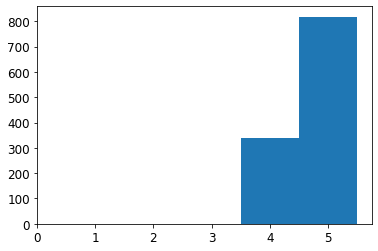

In [42]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(csH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

In [43]:
csIndx = sorted(list(set(serialAllData.index)))
csH = allDataDF.loc[csIndx,:]

csH = saveClusteredData(csH, scoreAsmts,"Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_AllData.csv")
csH

Age  Gender  Race   Wt   BMI  InitialHospDays  TotalHospDays  NYHA  \
ID                                                                             
Z103426  49.0     2.0   0.0  0.0  24.2             83.0           83.0   0.0   
Z103426  49.0     2.0   0.0  0.0   NaN              NaN           83.0   0.0   
Z103426  49.0     2.0   0.0  0.0   NaN              NaN           83.0   0.0   
Z103697  56.0     2.0   0.0  0.0   NaN             12.0           16.0   0.0   
Z103697  56.0     2.0   0.0  0.0   NaN              4.0           16.0   0.0   
...       ...     ...   ...  ...   ...              ...            ...   ...   
Z958018  55.0     2.0   0.0  0.0  16.1             14.0           30.0   0.0   
Z958018  55.0     2.0   0.0  0.0  19.1              2.0           30.0   0.0   
Z98220   46.0     1.0   0.0  0.0  27.1              4.0           16.0   0.0   
Z98220   46.0     1.0   0.0  0.0  31.0              7.0           16.0   0.0   
Z98220   46.0     1.0   0.0  0.0   NaN              5.0           16.0   0.0   

         MLHFS   AF  ...   HR   PV         MAP    PP       PPP   PPRatio  \
ID                   ...                                                   
Z103426    0.0  0.0  ...  0.0  0.0  143.666667  42.0  0.407767  0.666667   
Z103426    0.0  0.0  ...  0.0  0.0         NaN   NaN       NaN       NaN   
Z103426    0.0  0.0  ...  0.0  0.0         NaN   NaN       NaN       NaN   
Z103697    0.0  0.0  ...  0.0  0.0  132.333333  29.0  0.318681  0.216418   
Z103697    0.0  0.0  ...  0.0  0.0  144.666667  28.0  0.285714  0.184211   
...        ...  ...  ...  ...  ...         ...   ...       ...       ...   
Z958018    0.0  0.0  ...  0.0  0.0  151.666667  45.0  0.412844  0.266272   
Z958018    0.0  0.0  ...  0.0  0.0  117.666667  31.0  0.373494  0.191358   
Z98220     0.0  0.0  ...  0.0  0.0  187.333333  39.0  0.304688  0.286765   
Z98220     0.0  0.0  ...  0.0  0.0  193.333333  50.0  0.367647  0.378788   
Z98220     0.0  0.0  ...  0.0  0.0  155.000000  35.0  0.327103       NaN   

         Score  ScoreDeath  ScoreRehosp  ScoreReadmission  
ID                                                         
Z103426      5           4            5                 3  
Z103426      5           4            5                 3  
Z103426      2           5            1                 1  
Z103697      5           4            5                 3  
Z103697      5           4            5                 3  
...        ...         ...          ...               ...  
Z958018      5           4            5                 3  
Z958018      2           5            1                 1  
Z98220       5           4            5                 3  
Z98220       5           4            5                 3  
Z98220       5           4            5                 3  

[612 rows x 70 columns]

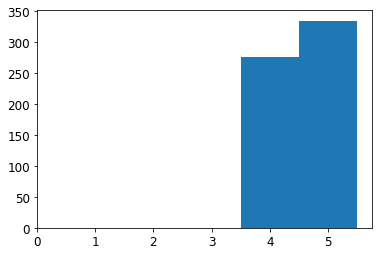

In [44]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(csH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()